# Dimensionality reduction

Notebook contains training and validation of XGBoost models in basic prediction case - multiclass classification (stages: I, II, III, IV), after dimensionality reduction. Different methods are tried: features preselection using ANOVA and mutual information criteria, and data decomposition using PCA.

In [1]:
import os
import pickle
import optuna
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from functools import partial
from xgboost.sklearn import XGBClassifier
from sklearn.decomposition import PCA
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import f_classif, mutual_info_classif
from sklearn.metrics import f1_score, accuracy_score, confusion_matrix, balanced_accuracy_score

warnings.filterwarnings('ignore')
optuna.logging.set_verbosity(optuna.logging.ERROR)

Define random seed to allow reproducibility

In [2]:
random_state = 42
np.random.seed(random_state)

Define directory paths to save results

In [3]:
output_dir_multiclass = '../results/updated_data/all_features/PDAC/dimensionality_reduction/multiclass/'
output_dir_binary = '../results/updated_data/all_features/PDAC/dimensionality_reduction/binary/'
output_dir_binary_2 = '../results/updated_data/all_features/PDAC/dimensionality_reduction/binary_I-II_vs_III-IV/'

Load training data

In [4]:
data_path = '../data/cleaned/updated/all_features/PDAC/'

train = pd.read_csv(os.path.join(data_path, 'train.csv'), sep=';')
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 93 entries, 0 to 92
Columns: 5331 entries, ID to CASC15
dtypes: float64(5327), object(4)
memory usage: 3.8+ MB


Prepare data for models training and dimensionality reduction (multiclass classification)

In [5]:
X_train_multiclass = train.copy(deep=True)

stratification_groups_multiclass = X_train_multiclass.apply(lambda row: f"{row['Group'].replace(' ', '_')}_{row['Stage']}", axis=1)
X_train_multiclass = X_train_multiclass.drop(columns=['ID', 'Sex', 'Age', 'Group'])

scaler = StandardScaler()
y_train_dr_multiclass = X_train_multiclass.loc[:, 'Stage']
X_train_dr_multiclass = scaler.fit_transform(X_train_multiclass.drop(columns=['Stage']))

dr_columns = X_train_multiclass.columns.drop('Stage')
X_train_dr_multiclass = pd.DataFrame(data=X_train_dr_multiclass, columns=dr_columns)

labels_encoding_multiclass = {
    'I': 0,
    'II': 1,
    'III': 2,
    'IV': 3
}
X_train_multiclass.loc[:, 'Stage'] = X_train_multiclass['Stage'].map(labels_encoding_multiclass)

Prepare data for models training and dimensionality reduction (binary classification)

In [6]:
X_train_binary = train.copy(deep=True)

binary_mapping = {
    'I': 'I-III',
    'II': 'I-III',
    'III': 'I-III',
    'IV': 'IV'
}
X_train_binary.loc[:, 'Stage'] = X_train_binary['Stage'].map(binary_mapping)

stratification_groups_binary = X_train_binary.apply(lambda row: f"{row['Group'].replace(' ', '_')}_{row['Stage']}", axis=1)
X_train_binary = X_train_binary.loc[:, ~X_train_binary.columns.isin(['ID', 'Sex', 'Age', 'Group'])]

scaler = StandardScaler()
y_train_dr_binary = X_train_binary.loc[:, 'Stage']
X_train_dr_binary = scaler.fit_transform(X_train_binary.drop(columns=['Stage']))

dr_columns = X_train_binary.columns.drop('Stage')
X_train_dr_binary = pd.DataFrame(data=X_train_dr_binary, columns=dr_columns)

labels_encoding_binary = {
    'I-III': 0,
    'IV': 1
}
X_train_binary.loc[:, 'Stage'] = X_train_binary['Stage'].map(labels_encoding_binary)

Prepare data for models training and dimensionality reduction (binary classification, stages I-II vs III-IV)

In [7]:
X_train_binary_2 = train.copy(deep=True)

binary_2_mapping = {
    'I': 'I-II',
    'II': 'I-II',
    'III': 'III-IV',
    'IV': 'III-IV'
}
X_train_binary_2.loc[:, 'Stage'] = X_train_binary_2['Stage'].map(binary_2_mapping)

stratification_groups_binary_2 = X_train_binary_2.apply(lambda row: f"{row['Group'].replace(' ', '_')}_{row['Stage']}", axis=1)
X_train_binary_2 = X_train_binary_2.loc[:, ~X_train_binary_2.columns.isin(['ID', 'Sex', 'Age', 'Group'])]

scaler = StandardScaler()
y_train_dr_binary_2 = X_train_binary_2.loc[:, 'Stage']
X_train_dr_binary_2 = scaler.fit_transform(X_train_binary_2.drop(columns=['Stage']))

dr_columns = X_train_binary_2.columns.drop('Stage')
X_train_dr_binary_2 = pd.DataFrame(data=X_train_dr_binary_2, columns=dr_columns)

labels_encoding_binary_2 = {
    'I-II': 0,
    'III-IV': 1
}
X_train_binary_2.loc[:, 'Stage'] = X_train_binary_2['Stage'].map(labels_encoding_binary_2)

Define a function for selecting features which scores are in the given percentile

In [8]:
def select_by_percentile(scores, percentile):
    threshold = np.percentile(scores, percentile)

    return np.where(scores > threshold)

Define functions for cross validation

In [9]:
def stratified_cross_val_score(
        estimator,
        df,
        stratification_groups,
        label_col,
        scoring,
        n_splits=5
):
    scores = np.zeros(n_splits)
    skf = StratifiedKFold(n_splits=n_splits)

    for i, (train_index, test_index) in enumerate(skf.split(df, stratification_groups)):
        y = df.loc[:, label_col]
        X = df.drop(columns=[label_col])

        estimator.fit(X=X.iloc[train_index], y=y.iloc[train_index], verbose=False)

        y_true = y.iloc[test_index]
        y_pred = estimator.predict(X.iloc[test_index])
        scores[i] = scoring(list(y_true), y_pred)

    return scores


def stratified_cross_val_predict(
        estimator,
        df,
        stratification_groups,
        label_col,
        n_splits=5
):
    y_pred = np.zeros(len(df))
    skf = StratifiedKFold(n_splits=n_splits)

    for train_index, test_index in skf.split(df, stratification_groups):
        y = df.loc[:, label_col]
        X = df.drop(columns=[label_col])

        estimator.fit(X=X.iloc[train_index], y=y.iloc[train_index], verbose=False)
        y_pred[test_index] = estimator.predict(X.iloc[test_index])

    return y_pred

Define objective function for hyperparameters optimization using Optuna

In [10]:
def objective(trial: optuna.Trial, X_train, stratification_groups, xgb_config, scoring):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 20, 150),
        'max_depth': trial.suggest_int('max_depth', 2, 8),
        'learning_rate': trial.suggest_float('learning_rate', 0.001, 0.3),
        'subsample': trial.suggest_float('subsample', 0.6, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0),
        'gamma': trial.suggest_float('gamma', 0.0, 1.0),
        **xgb_config
    }

    xgb = XGBClassifier(**params)

    scores = stratified_cross_val_score(
        estimator=xgb,
        df=X_train,
        stratification_groups=stratification_groups,
        label_col='Stage',
        scoring=scoring,
        n_splits=4
    )

    return scores.mean()

Define function for plotting confusion matrix

In [11]:
def plot_confusion_matrix(cm, labels, title, scores_subtitle, output_path=None):
    df_cm = pd.DataFrame(cm, index=labels, columns=labels)
    fig, ax = plt.subplots(figsize=(10, 6))
    sns.heatmap(df_cm, annot=True, cmap='Blues', fmt='g', linewidths=1)
    plt.setp(plt.gca().get_xticklabels(), ha='right', rotation=45)
    ax.set_ylabel('True Label')
    ax.set_xlabel('Predicted Label')
    ax.xaxis.set_ticks_position('top')
    ax.xaxis.set_label_position('top')
    plt.title(title, y=1.12, fontsize=12)
    plt.suptitle(scores_subtitle, y=0.08, fontsize=12)

    fig.show()
    
    if output_path is not None:
        fig.savefig(output_path, bbox_inches='tight')

## ANOVA

Preselection of features based on analysis of variance with different percentile thresholds. For each threshold, an XGBoost model is trained, fine-tuned, and cross-validated on the subset of initial columns.

### Multiclass classification

In [12]:
f_scores_multiclass, p_values_multiclass = f_classif(X_train_dr_multiclass, y_train_dr_multiclass)

results_anova_multiclass = pd.DataFrame(data={
    'feature': X_train_dr_multiclass.columns,
    'anova_score': f_scores_multiclass,
    'anova_p_value': p_values_multiclass
})

results_anova_multiclass.sort_values('anova_score', ascending=False).reset_index(drop=True).head(10)

,feature,anova_score,anova_p_value
0,LRRFIP1,6.208252,0.000705
1,MYEOV,6.009467,0.000892
2,MBNL3,5.639273,0.001387
3,ME1,5.318741,0.002036
4,FHL3,5.281144,0.002130
5,HPGD,4.779132,0.003907
6,MAP7D1,4.778755,0.003909
7,FAM63B,4.649586,0.004573
8,KIAA1731,4.621895,0.004730
9,KIAA0125,4.139578,0.008526


In [13]:
percentiles = [70, 80, 90, 95, 98]

xgb_config = {
    'objective': 'multi:softmax',
    'tree_method': 'gpu_hist',
    'gpu_id': 0,
    'random_state': random_state,
    'num_class': 4,
}

scoring_func = partial(f1_score, average='weighted')

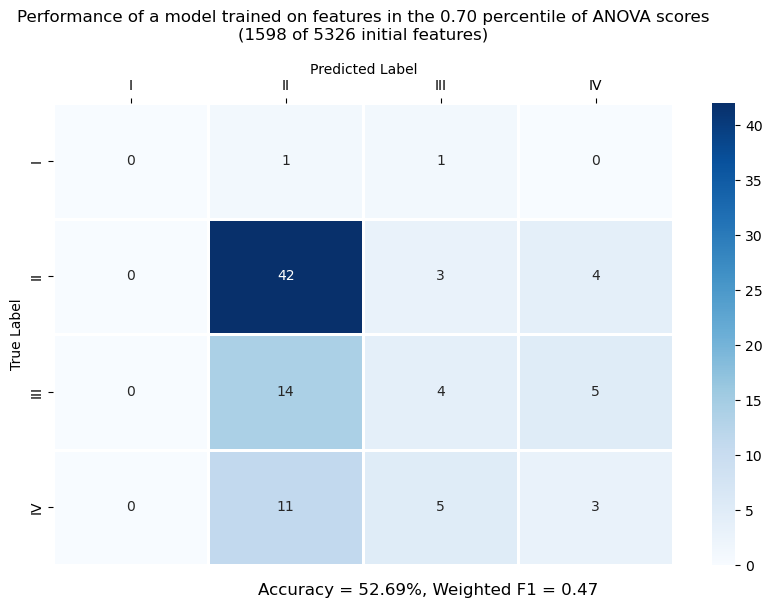

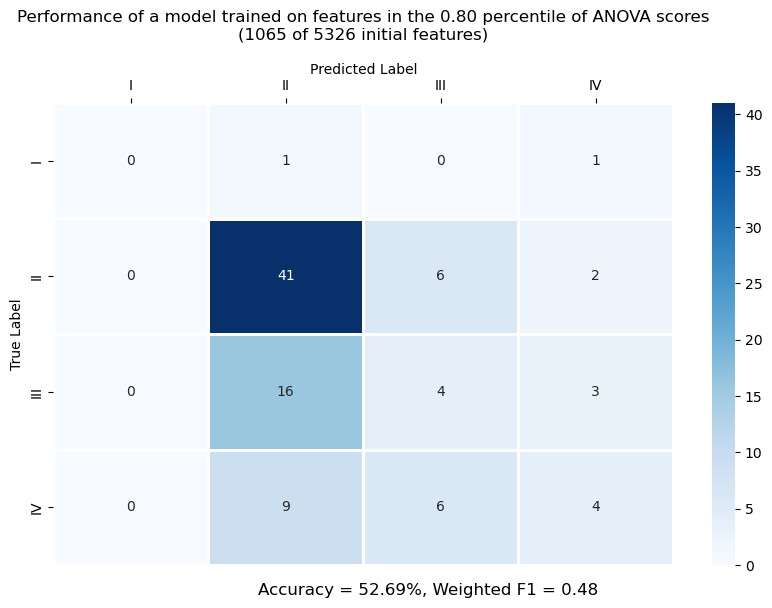

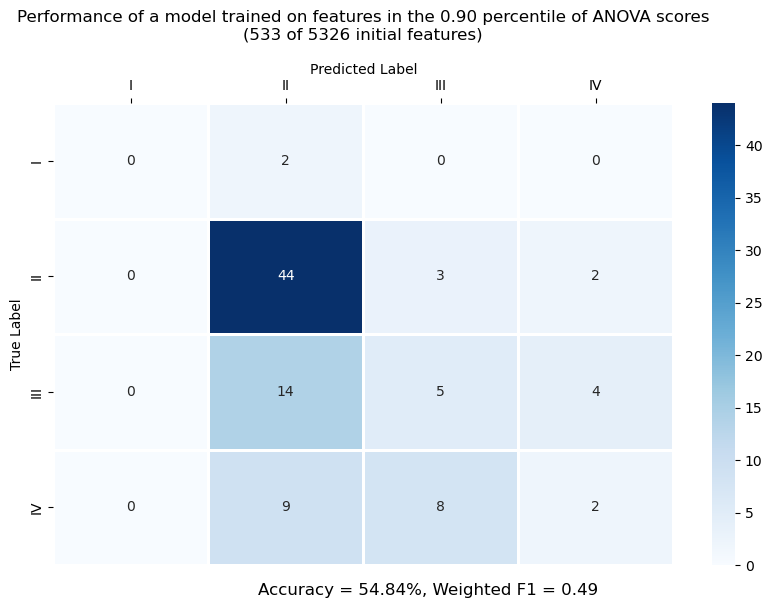

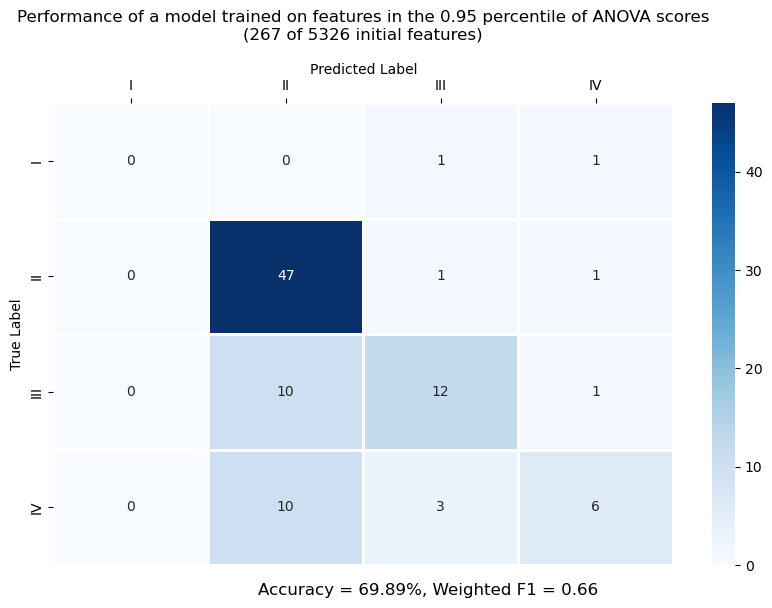

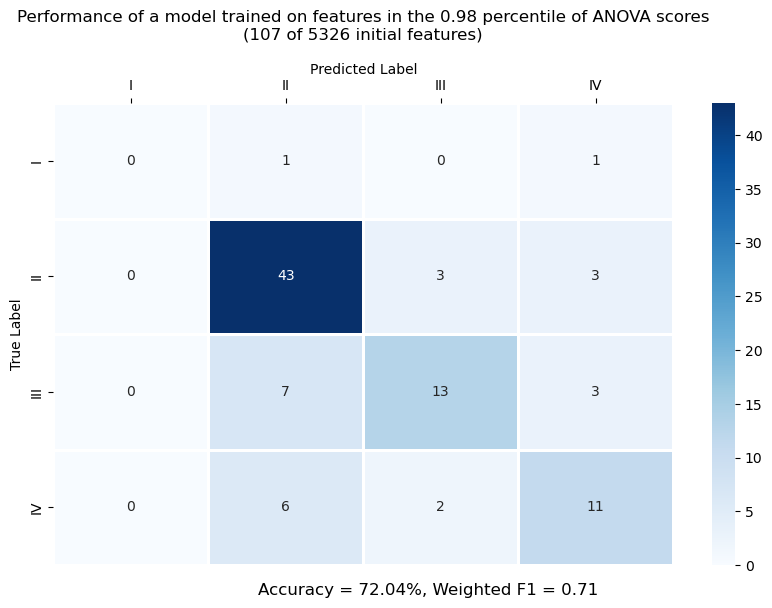

In [14]:
for percentile in percentiles:
    features_indices = select_by_percentile(f_scores_multiclass, percentile)
    best_features = X_train_dr_multiclass.columns[features_indices].tolist()
    X_train_reduced = X_train_multiclass.loc[:, best_features + ['Stage']]

    objective_func = partial(
        objective,
        X_train=X_train_reduced,
        stratification_groups=stratification_groups_multiclass,
        xgb_config=xgb_config,
        scoring=scoring_func
    )
    study = optuna.create_study(direction='maximize')
    study.optimize(objective_func, n_trials=50)

    best_params = {**study.best_params, **xgb_config}
    best_xgb = XGBClassifier(**best_params)

    y_pred = stratified_cross_val_predict(
        estimator=best_xgb,
        df=X_train_reduced,
        stratification_groups=stratification_groups_multiclass,
        label_col='Stage',
        n_splits=10
    )
    y_true = list(X_train_reduced['Stage'].values)
    labels = list(labels_encoding_multiclass.keys())

    accuracy = accuracy_score(y_true, y_pred.astype(int))
    f1 = f1_score(y_true, y_pred.astype(int), average='weighted')
    cm = confusion_matrix(y_true, y_pred.astype(int))

    title = f'Performance of a model trained on features in the {percentile/100:.2f} percentile of ANOVA scores' \
            f'\n({len(features_indices[0])} of {len(X_train_dr_multiclass.columns)} initial features)'
    scores_subtitle = f'Accuracy = {accuracy*100:.2f}%, Weighted F1 = {f1:.2f}'
    
    filename = f'anova_{percentile}_percentile.png'
    plot_confusion_matrix(cm, labels, title, scores_subtitle, output_path=os.path.join(output_dir_multiclass, filename))
    
    filename = f'anova_{percentile}_percentile_used_features.obj'
    output_path=os.path.join(output_dir_multiclass, filename)
    with open(output_path, 'wb') as file:
        pickle.dump(best_features, file)

### Binary classification

In [15]:
f_scores_binary, p_values_binary = f_classif(X_train_dr_binary, y_train_dr_binary)

results_anova_binary = pd.DataFrame(data={
    'feature': X_train_dr_binary.columns,
    'anova_score': f_scores_binary,
    'anova_p_value': p_values_binary
})

results_anova_binary.sort_values('anova_score', ascending=False).reset_index(drop=True).head(10)

,feature,anova_score,anova_p_value
0,MYEOV,17.057504,0.000080
1,MBNL3,14.366188,0.000270
2,MAP7D1,12.161587,0.000753
3,LANCL3,10.950010,0.001342
4,HPGD,10.617045,0.001576
5,KIAA0125,10.534809,0.001640
6,KIAA1731,10.455655,0.001704
7,LRRFIP1,10.296559,0.001841
8,ANK1,9.249822,0.003077
9,CCDC7,8.917043,0.003629


In [16]:
percentiles = [70, 80, 90, 95, 98]

xgb_config = {
    'objective': 'binary:logistic',
    'tree_method': 'gpu_hist',
    'gpu_id': 0,
    'random_state': random_state,
}

scoring_func = balanced_accuracy_score

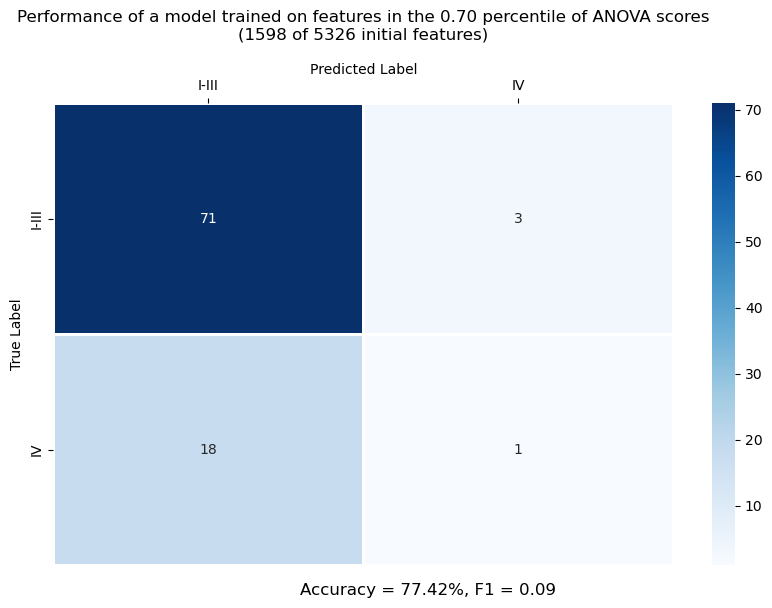

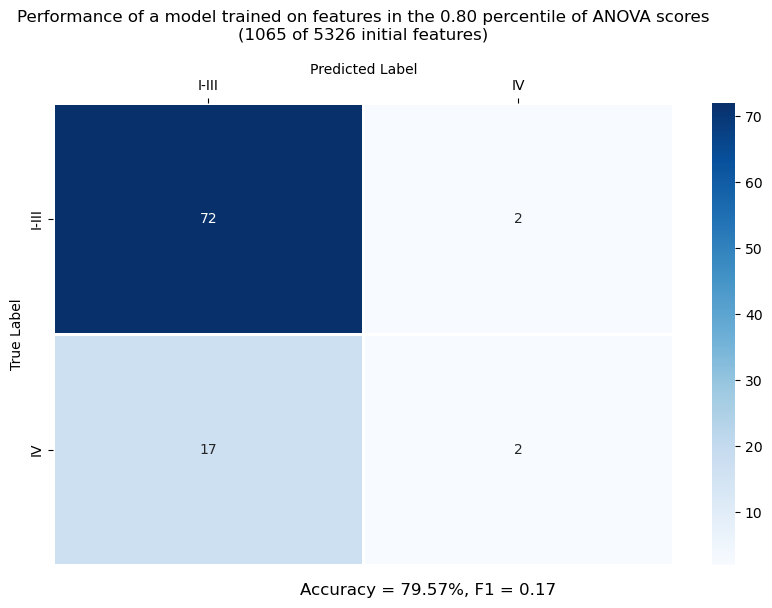

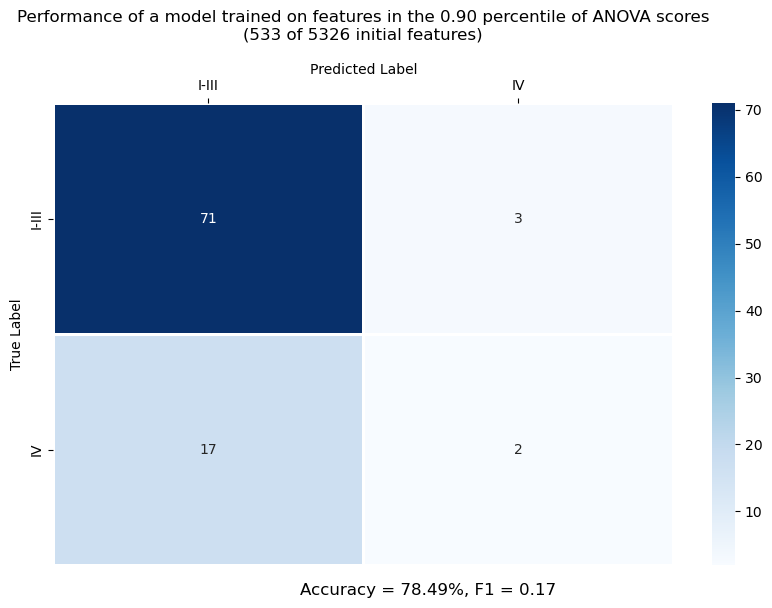

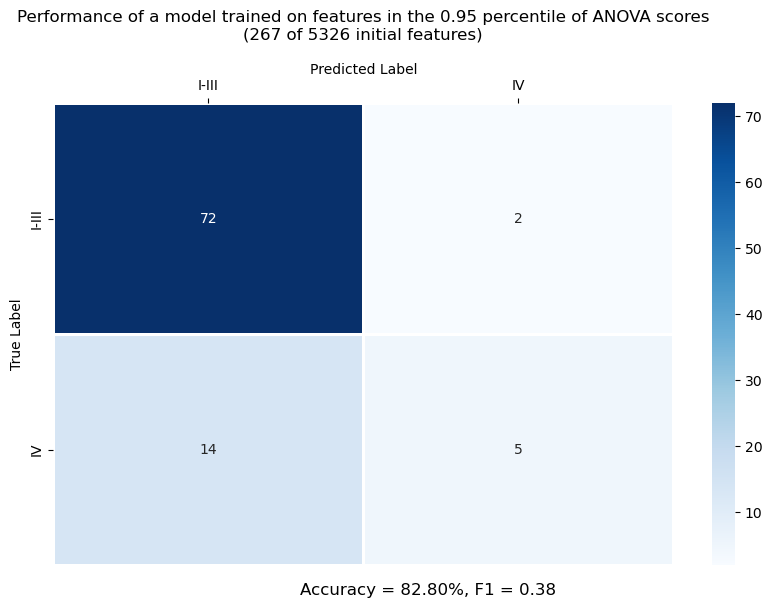

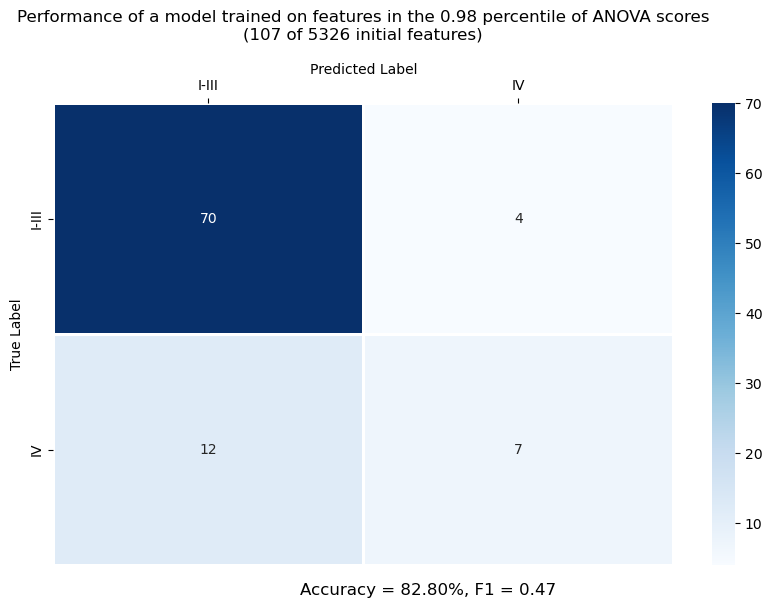

In [17]:
for percentile in percentiles:
    features_indices = select_by_percentile(f_scores_binary, percentile)
    best_features = X_train_dr_binary.columns[features_indices].tolist()
    X_train_reduced = X_train_binary.loc[:, best_features + ['Stage']]

    objective_func = partial(
        objective,
        X_train=X_train_reduced,
        stratification_groups=stratification_groups_binary,
        xgb_config=xgb_config,
        scoring=scoring_func
    )
    study = optuna.create_study(direction='maximize')
    study.optimize(objective_func, n_trials=50)

    best_params = {**study.best_params, **xgb_config}
    best_xgb = XGBClassifier(**best_params)

    y_pred = stratified_cross_val_predict(
        estimator=best_xgb,
        df=X_train_reduced,
        stratification_groups=stratification_groups_binary,
        label_col='Stage',
        n_splits=10
    )
    y_true = list(X_train_reduced['Stage'].values)
    labels = list(labels_encoding_binary.keys())

    accuracy = accuracy_score(y_true, y_pred.astype(int))
    f1 = f1_score(y_true, y_pred.astype(int))
    cm = confusion_matrix(y_true, y_pred.astype(int))

    title = f'Performance of a model trained on features in the {percentile/100:.2f} percentile of ANOVA scores' \
            f'\n({len(features_indices[0])} of {len(X_train_dr_binary.columns)} initial features)'
    scores_subtitle = f'Accuracy = {accuracy*100:.2f}%, F1 = {f1:.2f}'
    
    filename = f'anova_{percentile}_percentile.png'
    plot_confusion_matrix(cm, labels, title, scores_subtitle, output_path=os.path.join(output_dir_binary, filename))
    
    filename = f'anova_{percentile}_percentile_used_features.obj'
    output_path=os.path.join(output_dir_binary, filename)
    with open(output_path, 'wb') as file:
        pickle.dump(best_features, file)

### Binary classification (stages: I-II vs III-IV)

In [18]:
f_scores_binary_2, p_values_binary_2 = f_classif(X_train_dr_binary_2, y_train_dr_binary_2)

results_anova_binary_2 = pd.DataFrame(data={
    'feature': X_train_dr_binary_2.columns,
    'anova_score': f_scores_binary_2,
    'anova_p_value': p_values_binary_2
})

results_anova_binary_2.sort_values('anova_score', ascending=False).reset_index(drop=True).head(10)

,feature,anova_score,anova_p_value
0,LRRFIP1,13.586336,0.000387
1,FAM63B,12.767505,0.000567
2,MBNL3,9.934417,0.002197
3,DEFA3,9.847267,0.002292
4,SUGT1,9.823858,0.002319
5,ASGR2,9.447669,0.002790
6,RYR2,8.842991,0.003766
7,MAP7D1,8.799884,0.003848
8,RECQL5,8.706396,0.004032
9,SSBP4,8.576464,0.004303


In [19]:
percentiles = [70, 80, 90, 95, 98]

xgb_config = {
    'objective': 'binary:logistic',
    'tree_method': 'gpu_hist',
    'gpu_id': 0,
    'random_state': random_state,
}

scoring_func = balanced_accuracy_score

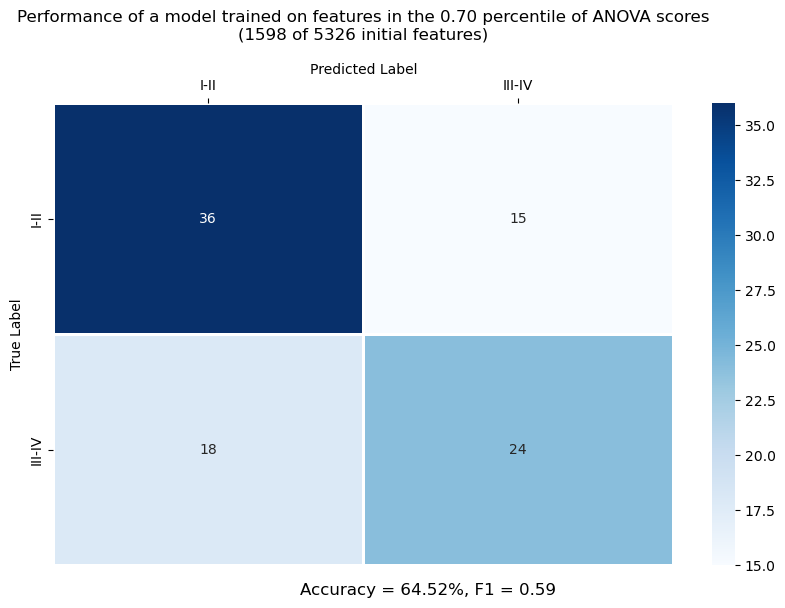

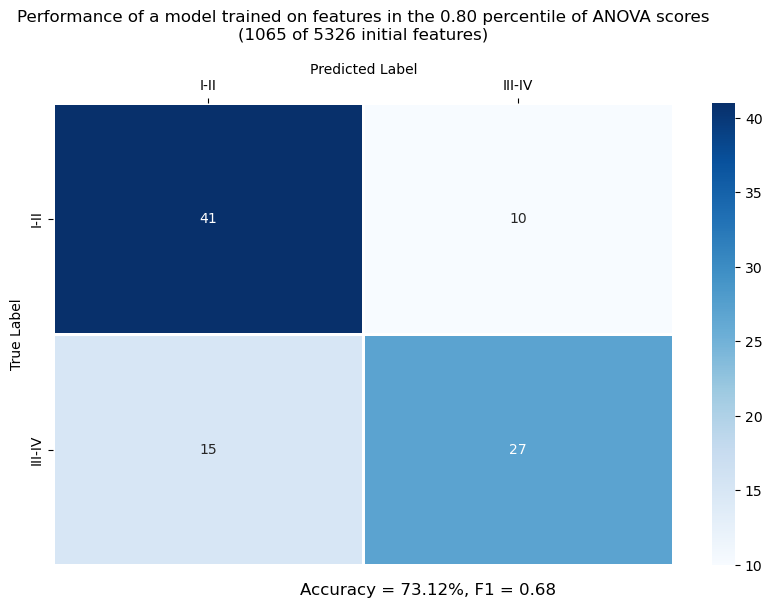

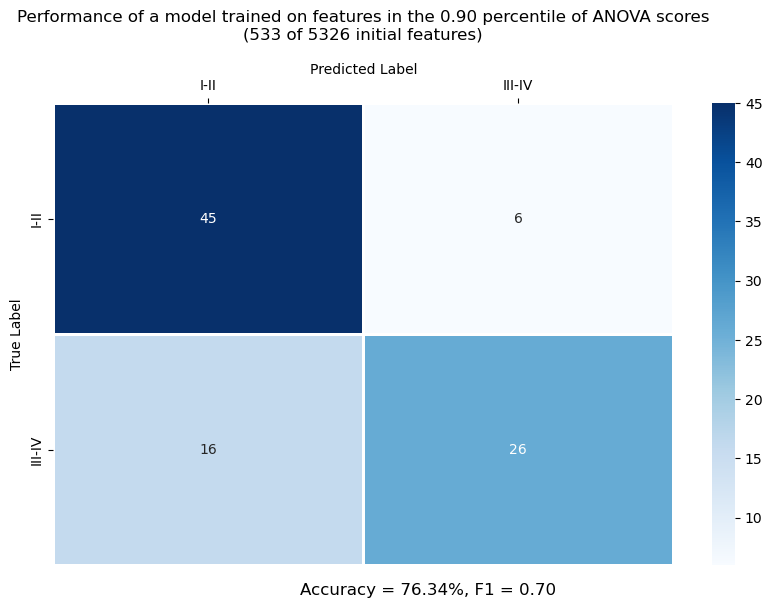

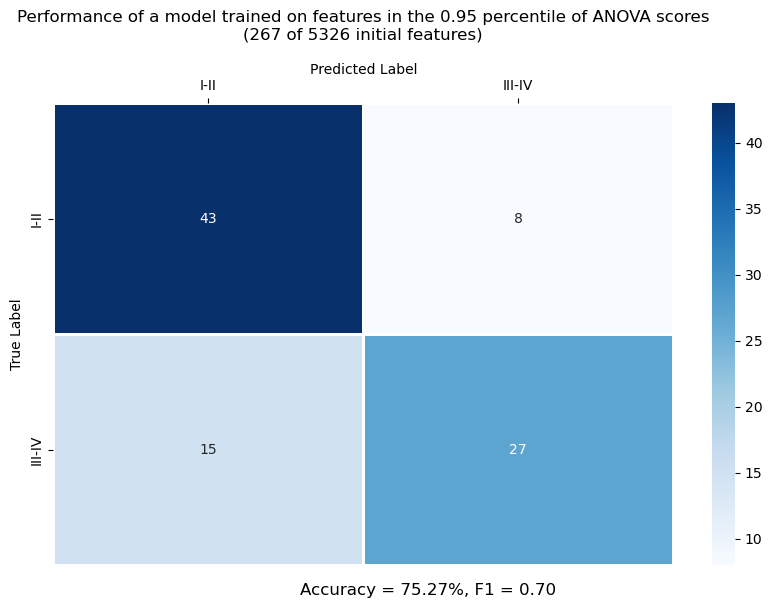

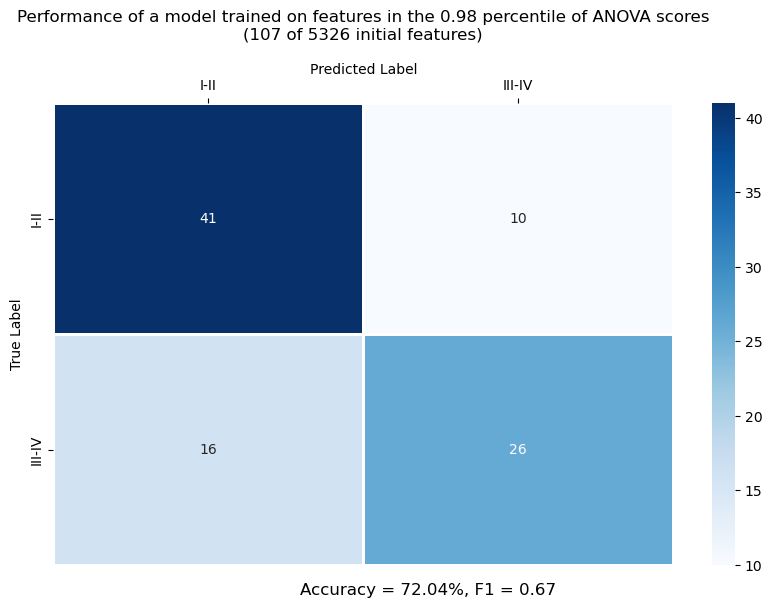

In [20]:
for percentile in percentiles:
    features_indices = select_by_percentile(f_scores_binary_2, percentile)
    best_features = X_train_dr_binary_2.columns[features_indices].tolist()
    X_train_reduced = X_train_binary_2.loc[:, best_features + ['Stage']]

    objective_func = partial(
        objective,
        X_train=X_train_reduced,
        stratification_groups=stratification_groups_binary_2,
        xgb_config=xgb_config,
        scoring=scoring_func
    )
    study = optuna.create_study(direction='maximize')
    study.optimize(objective_func, n_trials=50)

    best_params = {**study.best_params, **xgb_config}
    best_xgb = XGBClassifier(**best_params)

    y_pred = stratified_cross_val_predict(
        estimator=best_xgb,
        df=X_train_reduced,
        stratification_groups=stratification_groups_binary_2,
        label_col='Stage',
        n_splits=10
    )
    y_true = list(X_train_reduced['Stage'].values)
    labels = list(labels_encoding_binary_2.keys())

    accuracy = accuracy_score(y_true, y_pred.astype(int))
    f1 = f1_score(y_true, y_pred.astype(int))
    cm = confusion_matrix(y_true, y_pred.astype(int))

    title = f'Performance of a model trained on features in the {percentile/100:.2f} percentile of ANOVA scores' \
            f'\n({len(features_indices[0])} of {len(X_train_dr_binary_2.columns)} initial features)'
    scores_subtitle = f'Accuracy = {accuracy*100:.2f}%, F1 = {f1:.2f}'
    
    filename = f'anova_{percentile}_percentile.png'
    plot_confusion_matrix(cm, labels, title, scores_subtitle, output_path=os.path.join(output_dir_binary_2, filename))
    
    filename = f'anova_{percentile}_percentile_used_features.obj'
    output_path=os.path.join(output_dir_binary_2, filename)
    with open(output_path, 'wb') as file:
        pickle.dump(best_features, file)

## Mutual information

Preselection of features based on mutual information scores with different percentile thresholds. For each threshold, an XGBoost model is trained, fine-tuned, and cross-validated on the subset of initial columns.

### Multiclass classification

In [21]:
mi_scores_multiclass = mutual_info_classif(X_train_dr_multiclass, y_train_dr_multiclass, n_neighbors=3)

results_mi_multiclass = pd.DataFrame(data={
    'feature': X_train_dr_multiclass.columns,
    'mi_score': mi_scores_multiclass
})

results_mi_multiclass.sort_values('mi_score', ascending=False).reset_index(drop=True).head(10)

,feature,mi_score
0,MBNL2,0.288992
1,CD226,0.266750
2,APH1A,0.265066
3,TPM4,0.251111
4,S100A8,0.227444
5,STX3,0.213442
6,IL4R,0.211907
7,USP31,0.209349
8,DPCD,0.200587
9,AFF1,0.198193


In [22]:
percentiles = [70, 80, 90, 95, 98]

xgb_config = {
    'objective': 'multi:softmax',
    'tree_method': 'gpu_hist',
    'gpu_id': 0,
    'random_state': random_state,
    'num_class': 4,
}

scoring_func = partial(f1_score, average='weighted')

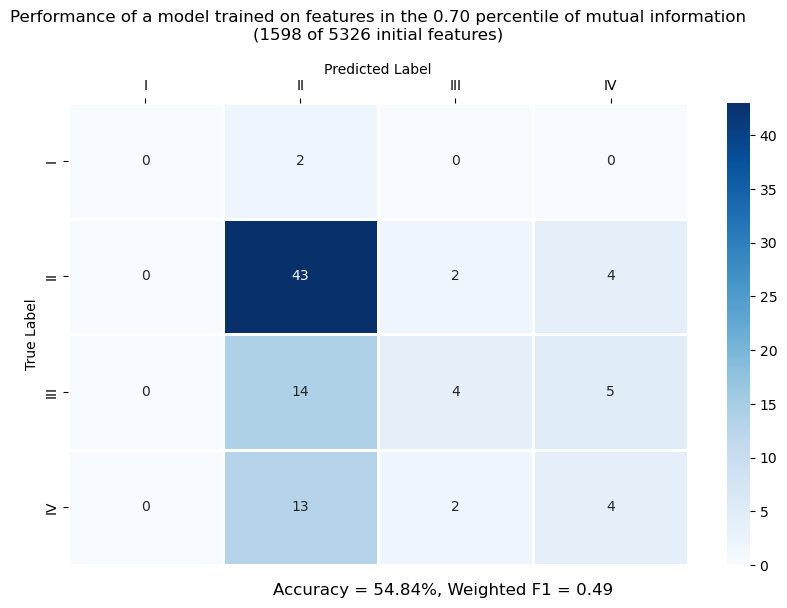

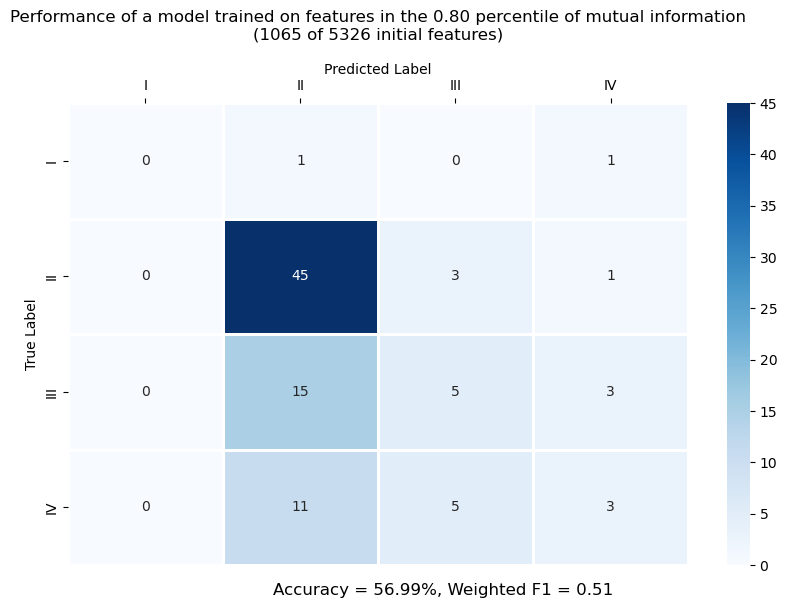

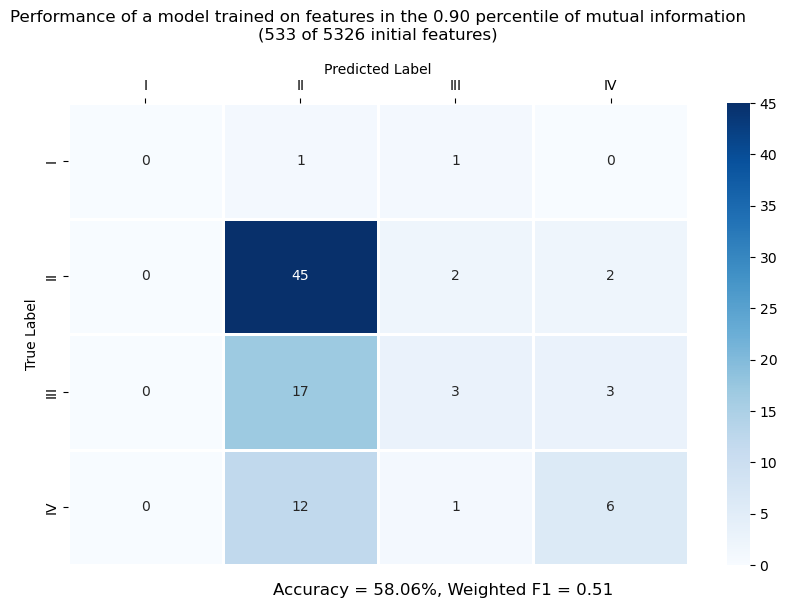

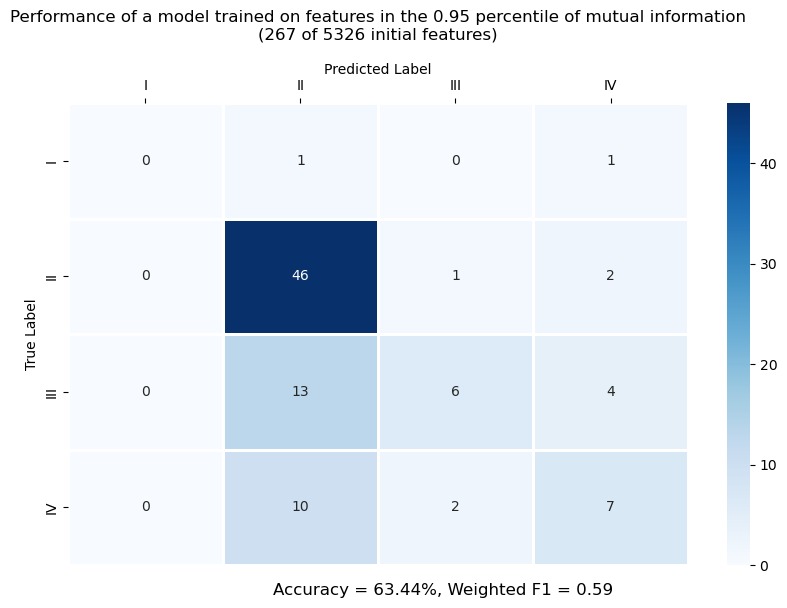

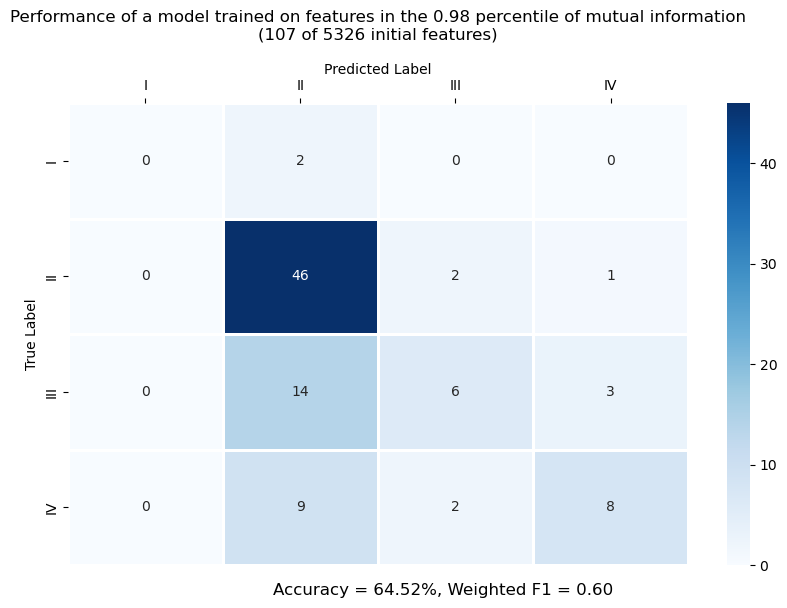

In [23]:
for percentile in percentiles:
    features_indices = select_by_percentile(mi_scores_multiclass, percentile)
    best_features = X_train_dr_multiclass.columns[features_indices].tolist()
    X_train_reduced = X_train_multiclass.loc[:, best_features + ['Stage']]

    objective_func = partial(
        objective,
        X_train=X_train_reduced,
        stratification_groups=stratification_groups_multiclass,
        xgb_config=xgb_config,
        scoring=scoring_func
    )
    study = optuna.create_study(direction='maximize')
    study.optimize(objective_func, n_trials=50)

    best_params = {**study.best_params, **xgb_config}
    best_xgb = XGBClassifier(**best_params)

    y_pred = stratified_cross_val_predict(
        estimator=best_xgb,
        df=X_train_reduced,
        stratification_groups=stratification_groups_multiclass,
        label_col='Stage',
        n_splits=10
    )
    y_true = list(X_train_reduced['Stage'].values)
    labels = list(labels_encoding_multiclass.keys())

    accuracy = accuracy_score(y_true, y_pred.astype(int))
    f1 = f1_score(y_true, y_pred.astype(int), average='weighted')
    cm = confusion_matrix(y_true, y_pred.astype(int))
    
    title = f'Performance of a model trained on features in the {percentile/100:.2f} percentile of mutual information' \
            f'\n({len(features_indices[0])} of {len(X_train_dr_multiclass.columns)} initial features)'
    scores_subtitle = f'Accuracy = {accuracy*100:.2f}%, Weighted F1 = {f1:.2f}'
    
    filename = f'mutual_information_{percentile}_percentile.png'
    plot_confusion_matrix(cm, labels, title, scores_subtitle, output_path=os.path.join(output_dir_multiclass, filename))
    
    filename = f'mutual_information_{percentile}_percentile_used_features.obj'
    output_path=os.path.join(output_dir_multiclass, filename)
    with open(output_path, 'wb') as file:
        pickle.dump(best_features, file)

### Binary classification

In [24]:
mi_scores_binary = mutual_info_classif(X_train_dr_binary, y_train_dr_binary, n_neighbors=3)

results_mi_binary = pd.DataFrame(data={
    'feature': X_train_dr_binary.columns,
    'mi_score': mi_scores_binary
})

results_mi_binary.sort_values('mi_score', ascending=False).reset_index(drop=True).head(10)

,feature,mi_score
0,CD226,0.184402
1,RHOF,0.169505
2,DPCD,0.169316
3,TYROBP,0.165041
4,APH1A,0.163136
5,FRG1,0.157151
6,TOLLIP,0.153934
7,IQGAP1,0.146968
8,CEP44,0.139802
9,UBE2M,0.134544


In [25]:
percentiles = [70, 80, 90, 95, 98]

xgb_config = {
    'objective': 'binary:logistic',
    'tree_method': 'gpu_hist',
    'gpu_id': 0,
    'random_state': random_state,
}

scoring_func = balanced_accuracy_score

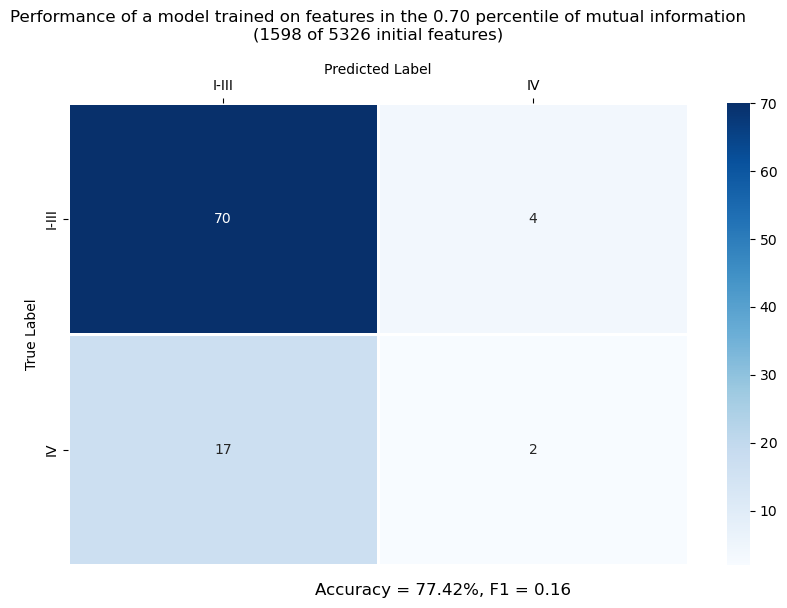

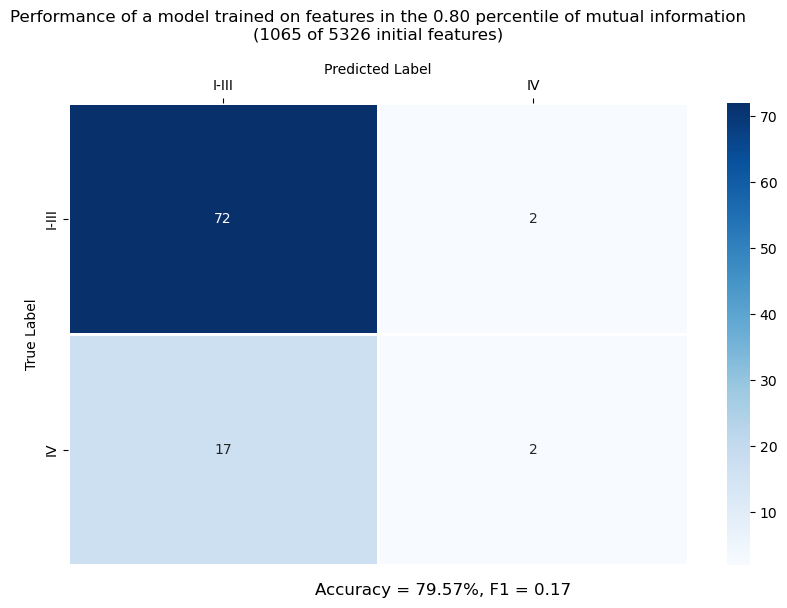

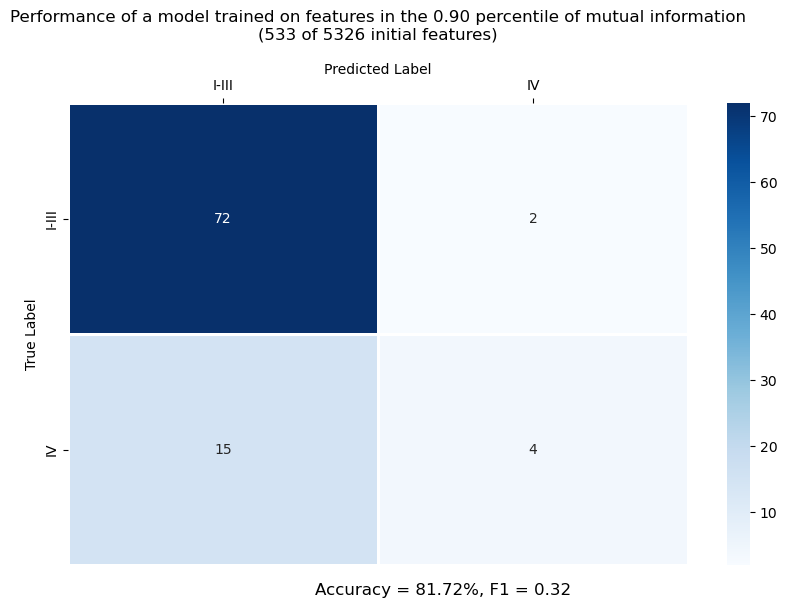

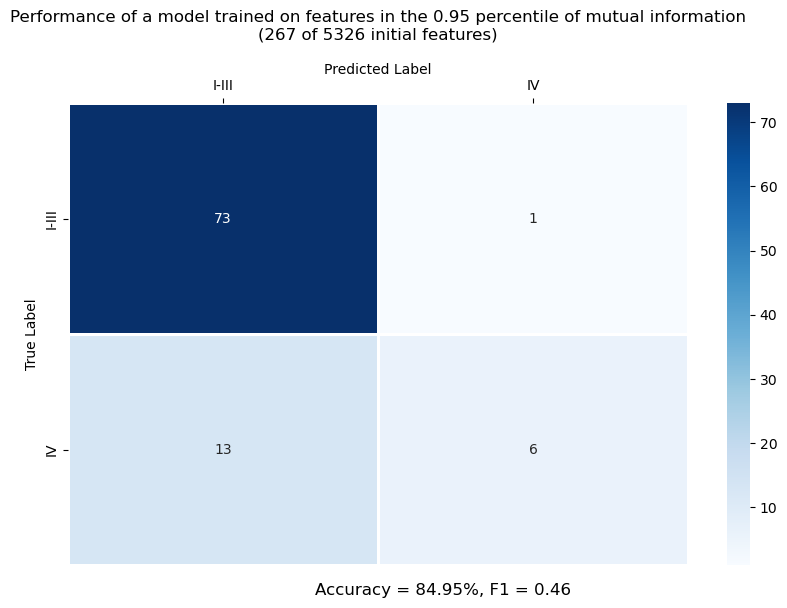

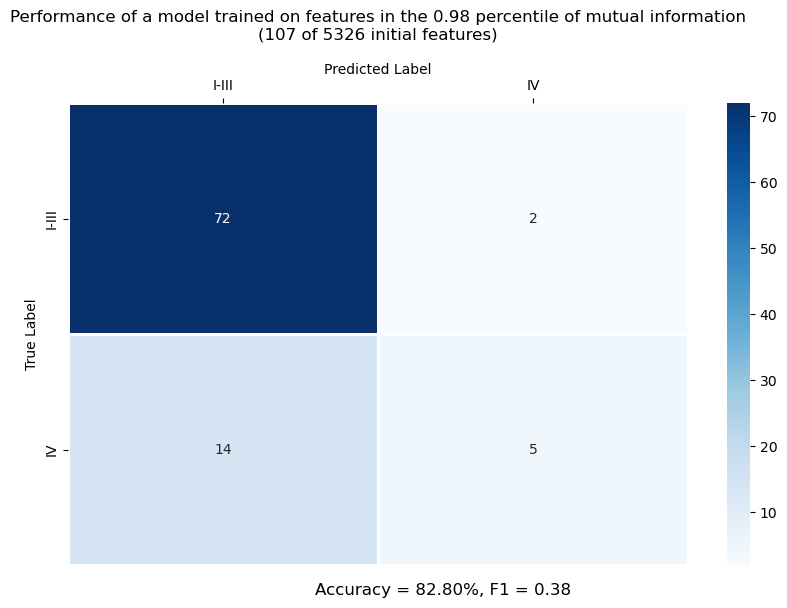

In [26]:
for percentile in percentiles:
    features_indices = select_by_percentile(mi_scores_binary, percentile)
    best_features = X_train_dr_binary.columns[features_indices].tolist()
    X_train_reduced = X_train_binary.loc[:, best_features + ['Stage']]

    objective_func = partial(
        objective,
        X_train=X_train_reduced,
        stratification_groups=stratification_groups_binary,
        xgb_config=xgb_config,
        scoring=scoring_func
    )
    study = optuna.create_study(direction='maximize')
    study.optimize(objective_func, n_trials=50)

    best_params = {**study.best_params, **xgb_config}
    best_xgb = XGBClassifier(**best_params)

    y_pred = stratified_cross_val_predict(
        estimator=best_xgb,
        df=X_train_reduced,
        stratification_groups=stratification_groups_binary,
        label_col='Stage',
        n_splits=10
    )
    y_true = list(X_train_reduced['Stage'].values)
    labels = list(labels_encoding_binary.keys())

    accuracy = accuracy_score(y_true, y_pred.astype(int))
    f1 = f1_score(y_true, y_pred.astype(int))
    cm = confusion_matrix(y_true, y_pred.astype(int))
    
    title = f'Performance of a model trained on features in the {percentile/100:.2f} percentile of mutual information' \
            f'\n({len(features_indices[0])} of {len(X_train_dr_binary.columns)} initial features)'
    scores_subtitle = f'Accuracy = {accuracy*100:.2f}%, F1 = {f1:.2f}'
    
    filename = f'mutual_information_{percentile}_percentile.png'
    plot_confusion_matrix(cm, labels, title, scores_subtitle, output_path=os.path.join(output_dir_binary, filename))
    
    filename = f'mutual_information_{percentile}_percentile_used_features.obj'
    output_path=os.path.join(output_dir_binary, filename)
    with open(output_path, 'wb') as file:
        pickle.dump(best_features, file)

### Binary classification (stages: I-II vs III-IV)

In [27]:
mi_scores_binary_2 = mutual_info_classif(X_train_dr_binary_2, y_train_dr_binary_2, n_neighbors=3)

results_mi_binary_2 = pd.DataFrame(data={
    'feature': X_train_dr_binary_2.columns,
    'mi_score': mi_scores_binary_2
})

results_mi_binary_2.sort_values('mi_score', ascending=False).reset_index(drop=True).head(10)

,feature,mi_score
0,MBNL2,0.240081
1,GNAZ,0.211426
2,ELP5,0.200430
3,CD226,0.196785
4,YWHAQ,0.195300
5,CD37,0.179430
6,LTB,0.179165
7,CYTH4,0.170519
8,ELOVL5,0.168549
9,GSDMD,0.164882


In [28]:
percentiles = [70, 80, 90, 95, 98]

xgb_config = {
    'objective': 'binary:logistic',
    'tree_method': 'gpu_hist',
    'gpu_id': 0,
    'random_state': random_state,
}

scoring_func = balanced_accuracy_score

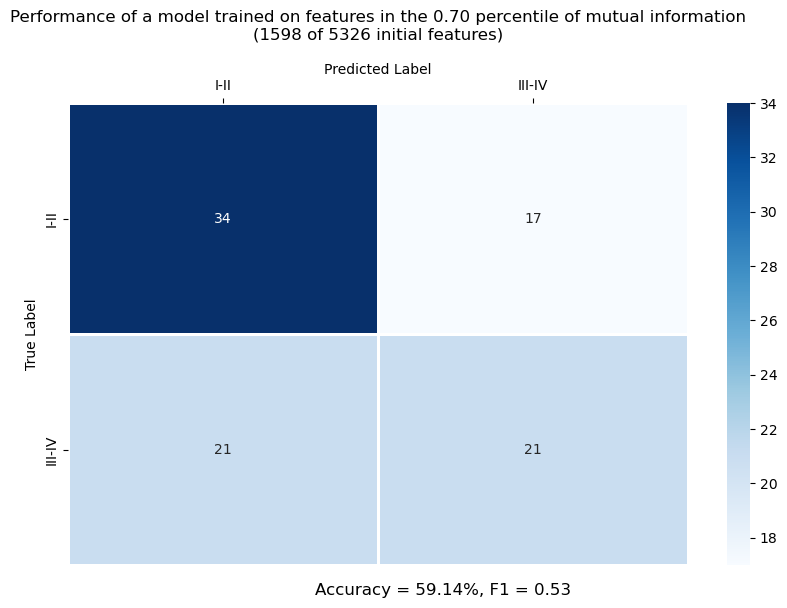

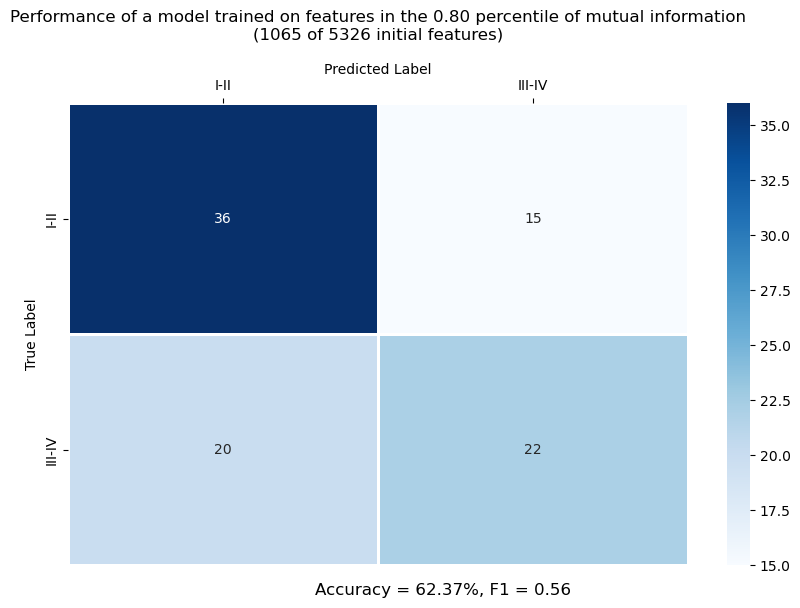

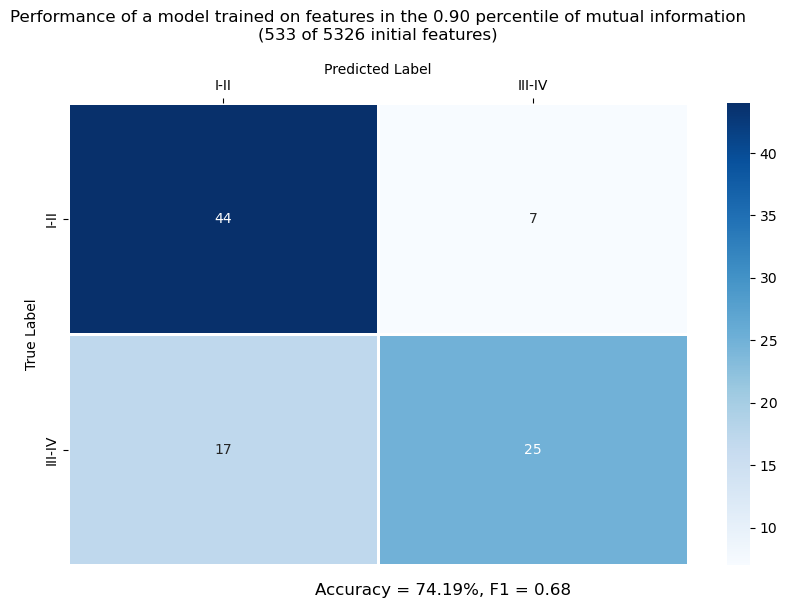

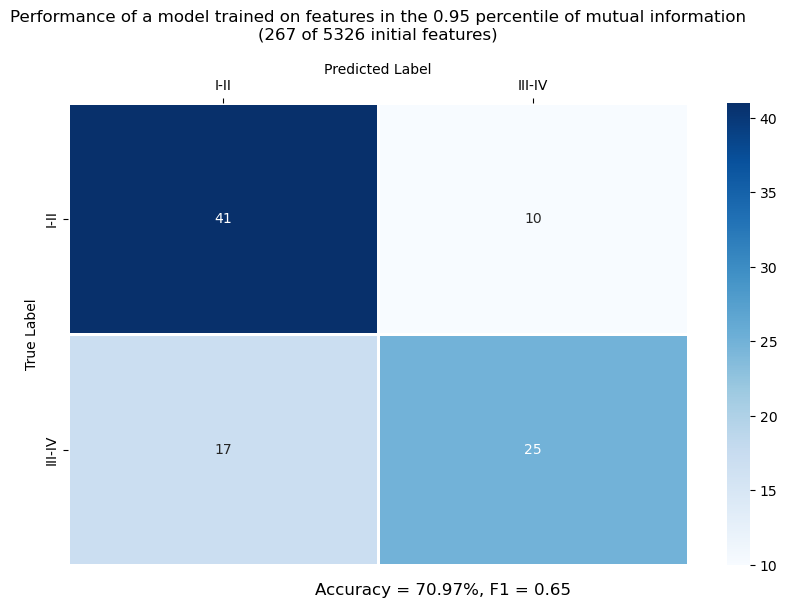

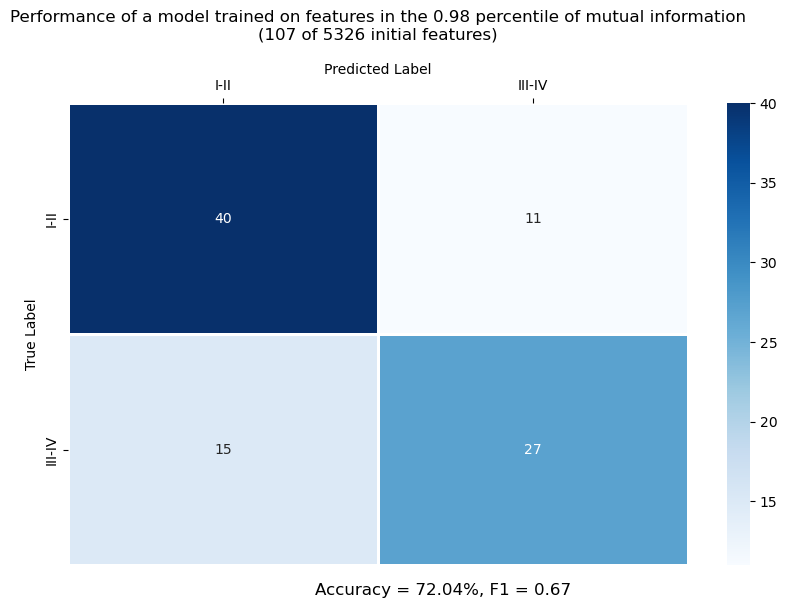

In [29]:
for percentile in percentiles:
    features_indices = select_by_percentile(mi_scores_binary_2, percentile)
    best_features = X_train_dr_binary_2.columns[features_indices].tolist()
    X_train_reduced = X_train_binary_2.loc[:, best_features + ['Stage']]

    objective_func = partial(
        objective,
        X_train=X_train_reduced,
        stratification_groups=stratification_groups_binary_2,
        xgb_config=xgb_config,
        scoring=scoring_func
    )
    study = optuna.create_study(direction='maximize')
    study.optimize(objective_func, n_trials=50)

    best_params = {**study.best_params, **xgb_config}
    best_xgb = XGBClassifier(**best_params)

    y_pred = stratified_cross_val_predict(
        estimator=best_xgb,
        df=X_train_reduced,
        stratification_groups=stratification_groups_binary_2,
        label_col='Stage',
        n_splits=10
    )
    y_true = list(X_train_reduced['Stage'].values)
    labels = list(labels_encoding_binary_2.keys())

    accuracy = accuracy_score(y_true, y_pred.astype(int))
    f1 = f1_score(y_true, y_pred.astype(int))
    cm = confusion_matrix(y_true, y_pred.astype(int))
    
    title = f'Performance of a model trained on features in the {percentile/100:.2f} percentile of mutual information' \
            f'\n({len(features_indices[0])} of {len(X_train_dr_binary_2.columns)} initial features)'
    scores_subtitle = f'Accuracy = {accuracy*100:.2f}%, F1 = {f1:.2f}'
    
    filename = f'mutual_information_{percentile}_percentile.png'
    plot_confusion_matrix(cm, labels, title, scores_subtitle, output_path=os.path.join(output_dir_binary_2, filename))
    
    filename = f'mutual_information_{percentile}_percentile_used_features.obj'
    output_path=os.path.join(output_dir_binary_2, filename)
    with open(output_path, 'wb') as file:
        pickle.dump(best_features, file)

## PCA

Decomposition of input features using PCA with different percentage thresholds of explained variance. For each threshold, an XGBoost model is trained, fine-tuned, and cross-validated on obtained components.

### Multiclass classification

In [30]:
explained_variance_thresholds = [0.7, 0.8, 0.9, 0.95, 0.98]

xgb_config = {
    'objective': 'multi:softmax',
    'tree_method': 'gpu_hist',
    'gpu_id': 0,
    'random_state': random_state,
    'num_class': 4,
}

scoring_func = partial(f1_score, average='weighted')

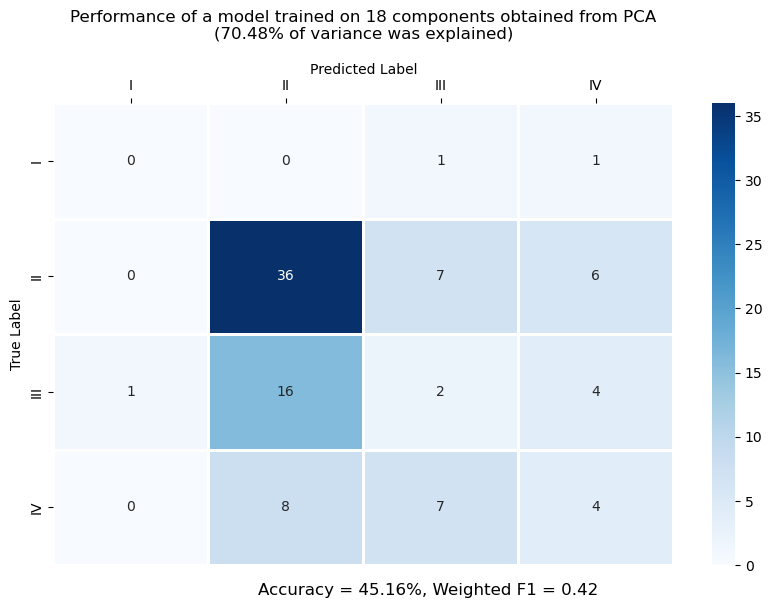

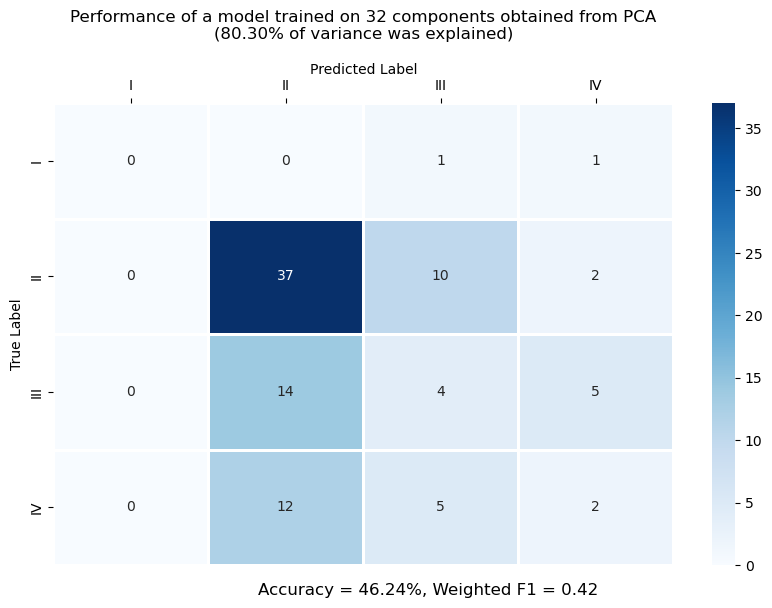

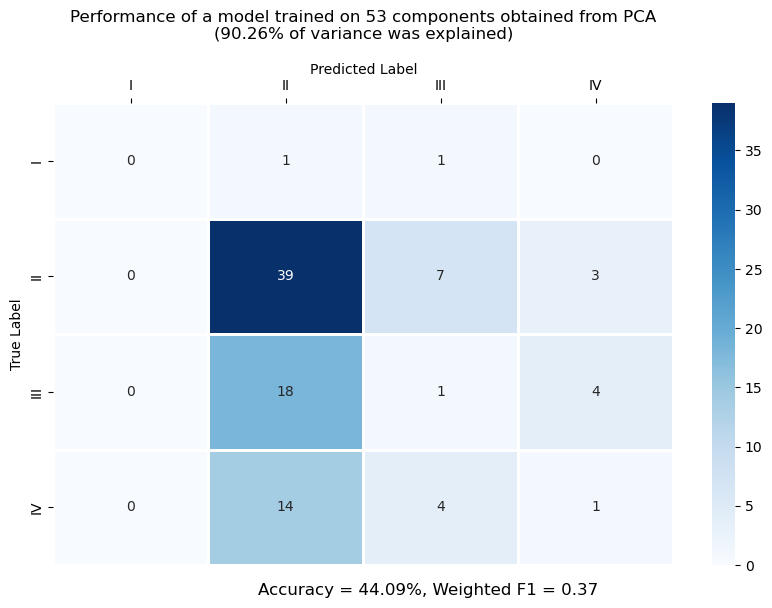

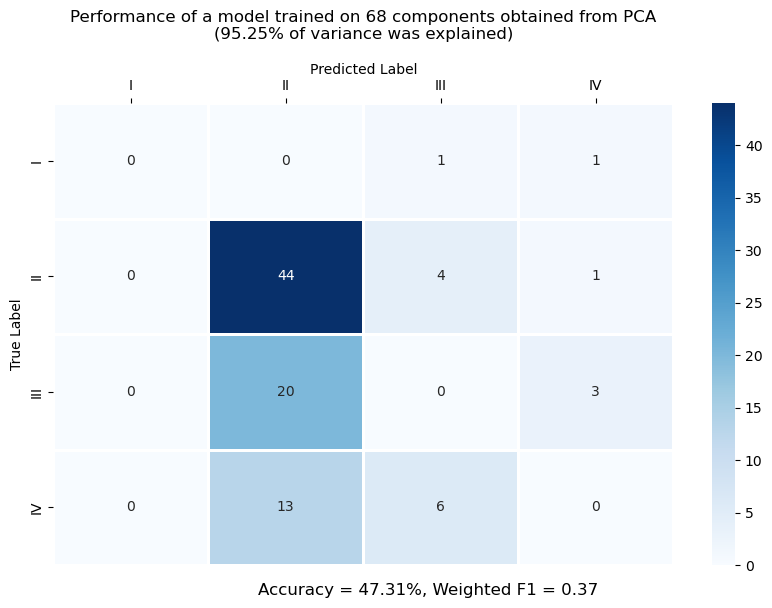

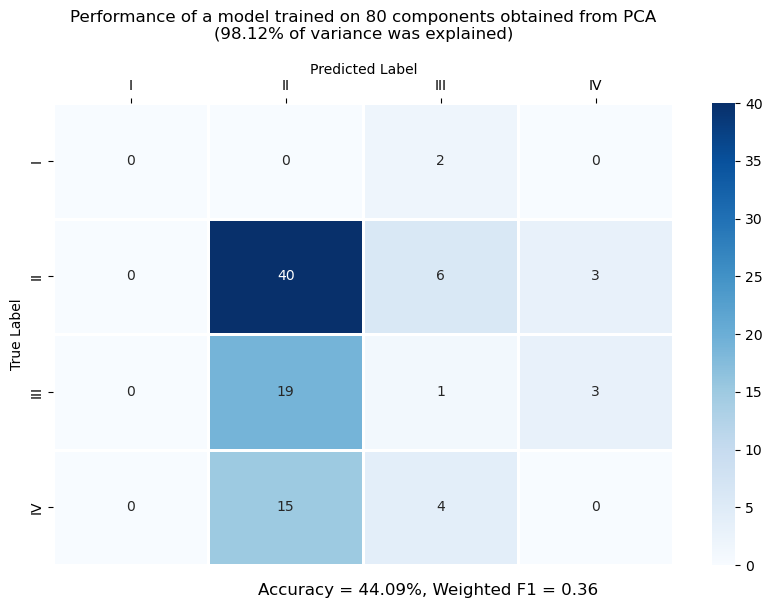

In [31]:
for explained_variance in explained_variance_thresholds:
    pca = PCA(n_components=explained_variance, random_state=random_state)
    X_train_reduced = pca.fit_transform(X_train_dr_multiclass)
    X_train_reduced = pd.DataFrame(X_train_reduced)
    X_train_reduced['Stage'] = X_train_multiclass['Stage'].values

    objective_func = partial(
        objective,
        X_train=X_train_reduced,
        stratification_groups=stratification_groups_multiclass,
        xgb_config=xgb_config,
        scoring=scoring_func
    )
    study = optuna.create_study(direction='maximize')
    study.optimize(objective_func, n_trials=50)

    best_params = {**study.best_params, **xgb_config}
    best_xgb = XGBClassifier(**best_params)

    y_pred = stratified_cross_val_predict(
        estimator=best_xgb,
        df=X_train_reduced,
        stratification_groups=stratification_groups_multiclass,
        label_col='Stage',
        n_splits=10
    )
    y_true = list(X_train_reduced['Stage'].values)
    labels = list(labels_encoding_multiclass.keys())

    accuracy = accuracy_score(y_true, y_pred.astype(int))
    f1 = f1_score(y_true, y_pred.astype(int), average='weighted')
    cm = confusion_matrix(y_true, y_pred.astype(int))
    
    variance_explained = pca.explained_variance_ratio_.sum() * 100
    title = f'Performance of a model trained on {pca.n_components_} components obtained from PCA' \
            f'\n({variance_explained:.2f}% of variance was explained)'
    scores_subtitle = f'Accuracy = {accuracy*100:.2f}%, Weighted F1 = {f1:.2f}'
    
    filename = f'pca_{int(variance_explained)}%_variance.png'
    plot_confusion_matrix(cm, labels, title, scores_subtitle, output_path=os.path.join(output_dir_multiclass, filename))

### Binary classification

In [32]:
explained_variance_thresholds = [0.7, 0.8, 0.9, 0.95, 0.98]

xgb_config = {
    'objective': 'binary:logistic',
    'tree_method': 'gpu_hist',
    'gpu_id': 0,
    'random_state': random_state,
}

scoring_func = balanced_accuracy_score

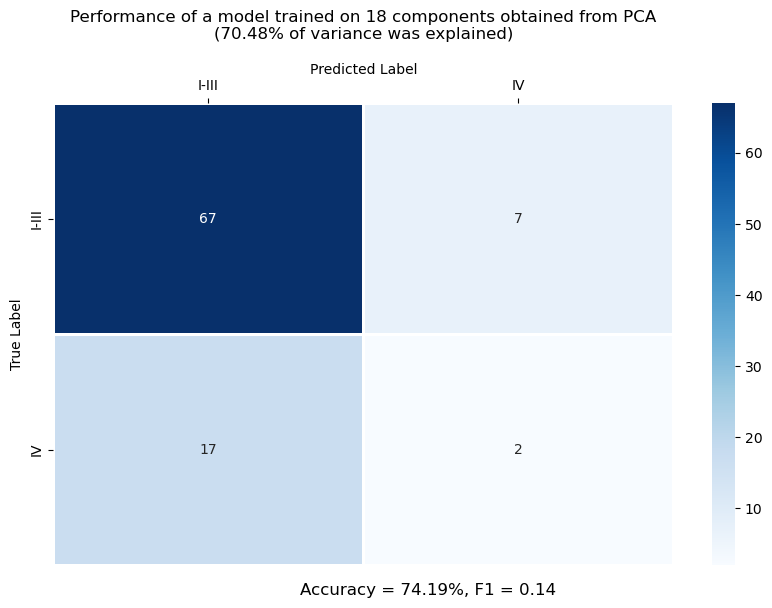

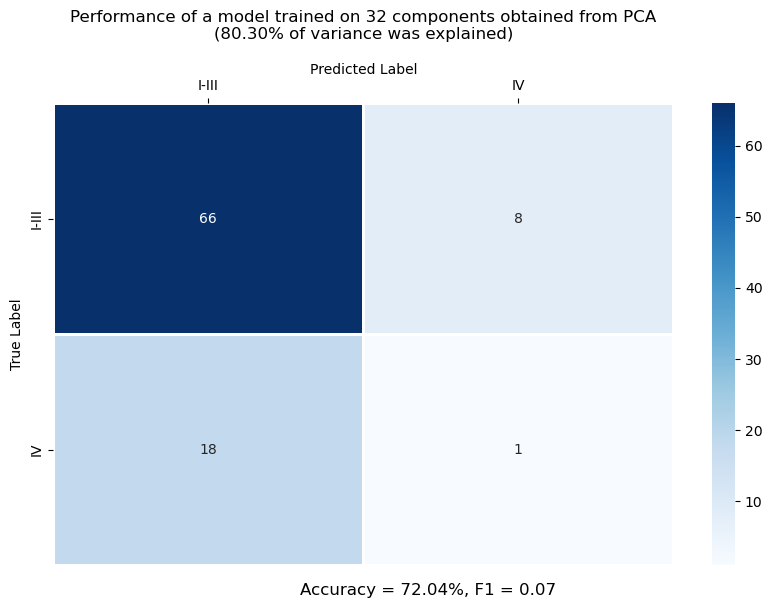

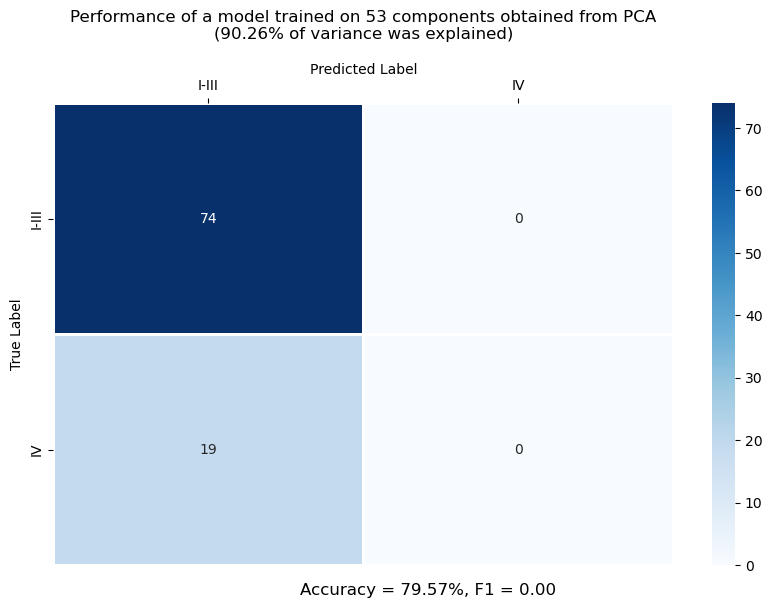

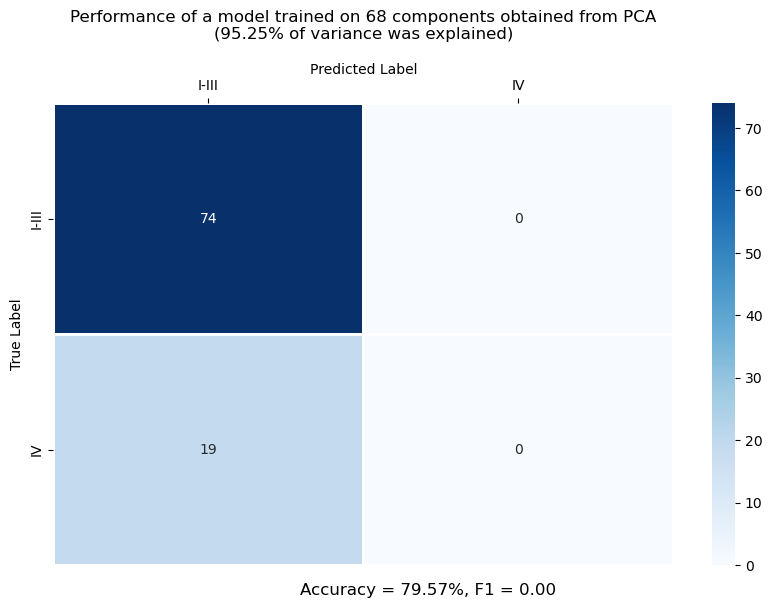

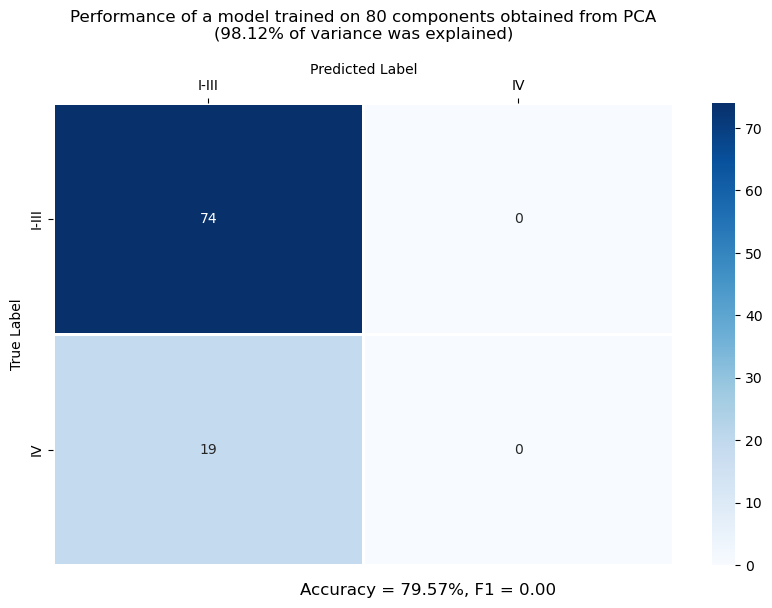

In [33]:
for explained_variance in explained_variance_thresholds:
    pca = PCA(n_components=explained_variance, random_state=random_state)
    X_train_reduced = pca.fit_transform(X_train_dr_binary)
    X_train_reduced = pd.DataFrame(X_train_reduced)
    X_train_reduced['Stage'] = X_train_binary['Stage'].values

    objective_func = partial(
        objective,
        X_train=X_train_reduced,
        stratification_groups=stratification_groups_binary,
        xgb_config=xgb_config,
        scoring=scoring_func
    )
    study = optuna.create_study(direction='maximize')
    study.optimize(objective_func, n_trials=50)

    best_params = {**study.best_params, **xgb_config}
    best_xgb = XGBClassifier(**best_params)

    y_pred = stratified_cross_val_predict(
        estimator=best_xgb,
        df=X_train_reduced,
        stratification_groups=stratification_groups_binary,
        label_col='Stage',
        n_splits=10
    )
    y_true = list(X_train_reduced['Stage'].values)
    labels = list(labels_encoding_binary.keys())

    accuracy = accuracy_score(y_true, y_pred.astype(int))
    f1 = f1_score(y_true, y_pred.astype(int))
    cm = confusion_matrix(y_true, y_pred.astype(int))
    
    variance_explained = pca.explained_variance_ratio_.sum() * 100
    title = f'Performance of a model trained on {pca.n_components_} components obtained from PCA' \
            f'\n({variance_explained:.2f}% of variance was explained)'
    scores_subtitle = f'Accuracy = {accuracy*100:.2f}%, F1 = {f1:.2f}'
    
    filename = f'pca_{int(variance_explained)}%_variance.png'
    plot_confusion_matrix(cm, labels, title, scores_subtitle, output_path=os.path.join(output_dir_binary, filename))

### Binary classification (stages: I-II vs III-IV)

In [34]:
explained_variance_thresholds = [0.7, 0.8, 0.9, 0.95, 0.98]

xgb_config = {
    'objective': 'binary:logistic',
    'tree_method': 'gpu_hist',
    'gpu_id': 0,
    'random_state': random_state,
}

scoring_func = balanced_accuracy_score

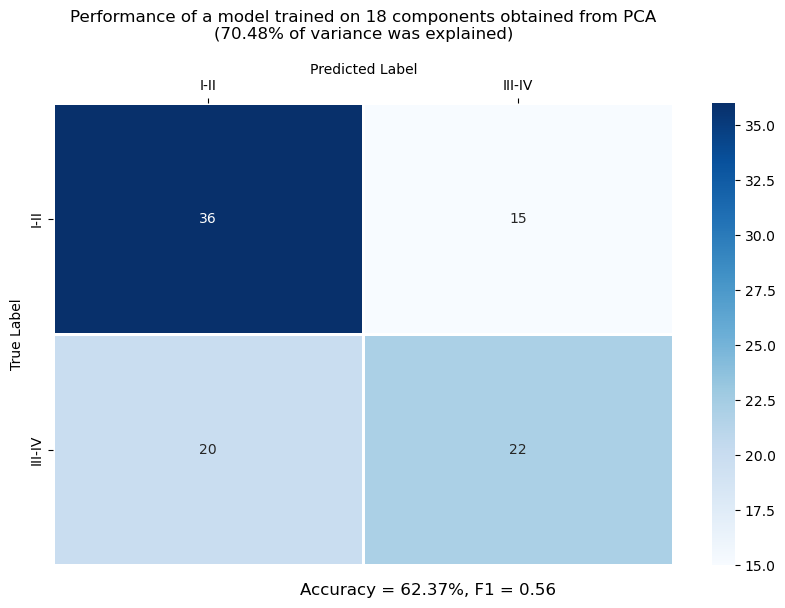

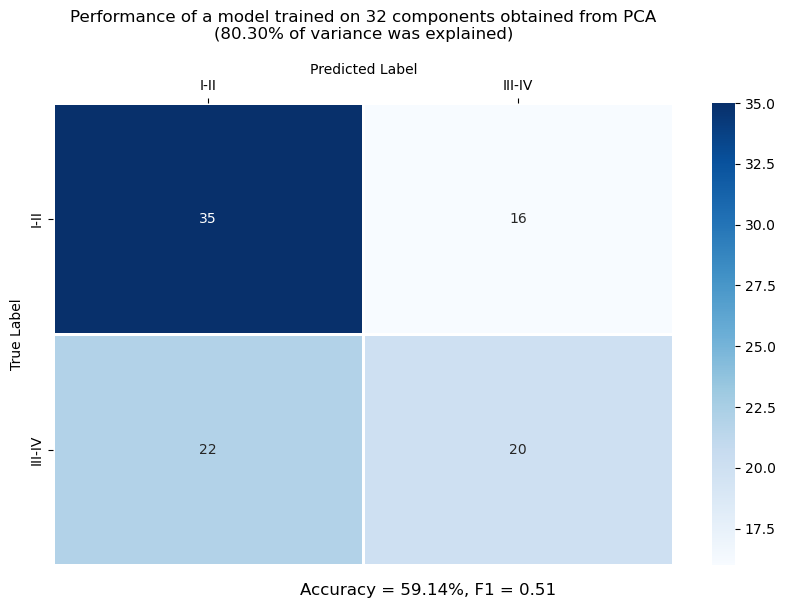

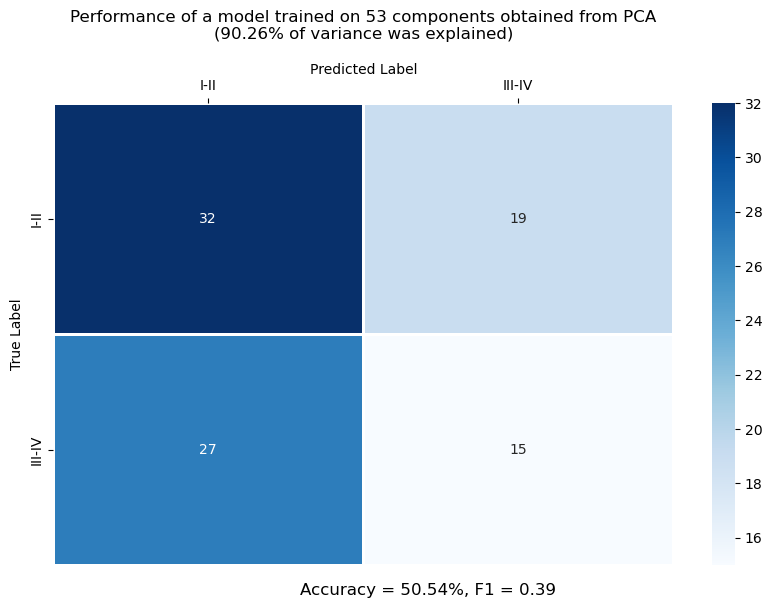

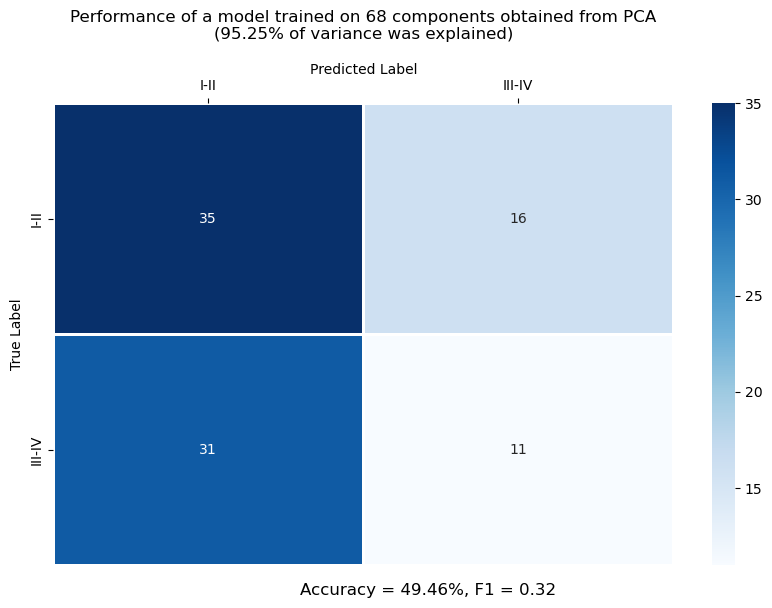

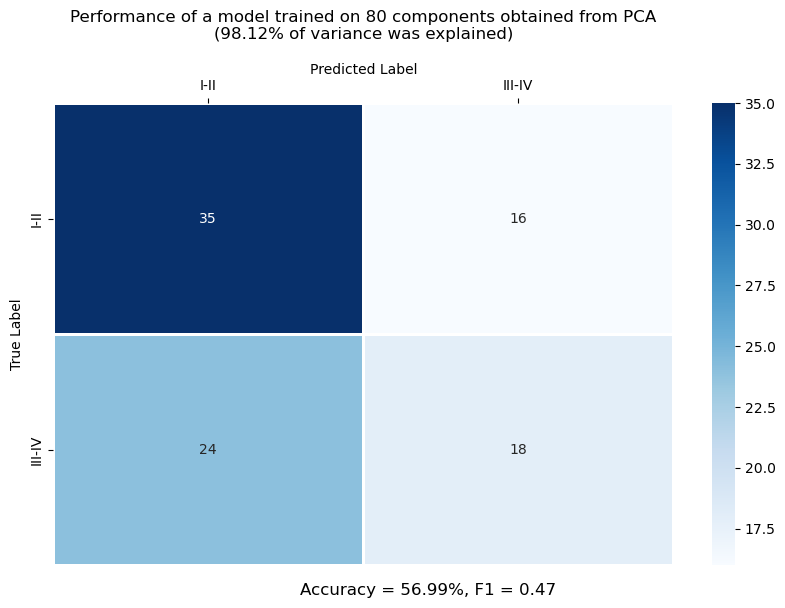

In [35]:
for explained_variance in explained_variance_thresholds:
    pca = PCA(n_components=explained_variance, random_state=random_state)
    X_train_reduced = pca.fit_transform(X_train_dr_binary_2)
    X_train_reduced = pd.DataFrame(X_train_reduced)
    X_train_reduced['Stage'] = X_train_binary_2['Stage'].values

    objective_func = partial(
        objective,
        X_train=X_train_reduced,
        stratification_groups=stratification_groups_binary_2,
        xgb_config=xgb_config,
        scoring=scoring_func
    )
    study = optuna.create_study(direction='maximize')
    study.optimize(objective_func, n_trials=50)

    best_params = {**study.best_params, **xgb_config}
    best_xgb = XGBClassifier(**best_params)

    y_pred = stratified_cross_val_predict(
        estimator=best_xgb,
        df=X_train_reduced,
        stratification_groups=stratification_groups_binary_2,
        label_col='Stage',
        n_splits=10
    )
    y_true = list(X_train_reduced['Stage'].values)
    labels = list(labels_encoding_binary_2.keys())

    accuracy = accuracy_score(y_true, y_pred.astype(int))
    f1 = f1_score(y_true, y_pred.astype(int))
    cm = confusion_matrix(y_true, y_pred.astype(int))
    
    variance_explained = pca.explained_variance_ratio_.sum() * 100
    title = f'Performance of a model trained on {pca.n_components_} components obtained from PCA' \
            f'\n({variance_explained:.2f}% of variance was explained)'
    scores_subtitle = f'Accuracy = {accuracy*100:.2f}%, F1 = {f1:.2f}'
    
    filename = f'pca_{int(variance_explained)}%_variance.png'
    plot_confusion_matrix(cm, labels, title, scores_subtitle, output_path=os.path.join(output_dir_binary_2, filename))

## Combined criteria

Preselection of features based on combined criteria of ANOVA and mutual information with different percentile thresholds. For each threshold, an XGBoost model is trained, fine-tuned, and cross-validated on the subset of initial columns.

### Multiclass classification

In [36]:
anova_features_order = np.zeros(f_scores_multiclass.size, dtype=int)
anova_features_order[np.argsort(f_scores_multiclass)] = np.arange(f_scores_multiclass.size)

mi_features_order = np.zeros(mi_scores_multiclass.size, dtype=int)
mi_features_order[np.argsort(mi_scores_multiclass)] = np.arange(mi_scores_multiclass.size)

features_order = anova_features_order + mi_features_order
results_combined_criteria = pd.DataFrame(data={
    'feature': X_train_dr_multiclass.columns,
    'order': features_order
})
results_combined_criteria.sort_values('order', ascending=False).reset_index(drop=True).head(10)

,feature,order
0,ANK1,10617
1,RECQL5,10610
2,ASGR2,10599
3,LANCL3,10555
4,MAP7D1,10549
5,LRRFIP1,10543
6,KLHL35,10535
7,SUGT1,10519
8,OLA1,10515
9,TUBA1B,10510


In [37]:
percentiles = [70, 80, 90, 95, 98]

xgb_config = {
    'objective': 'multi:softmax',
    'tree_method': 'gpu_hist',
    'gpu_id': 0,
    'random_state': random_state,
    'num_class': 4,
}

scoring_func = partial(f1_score, average='weighted')

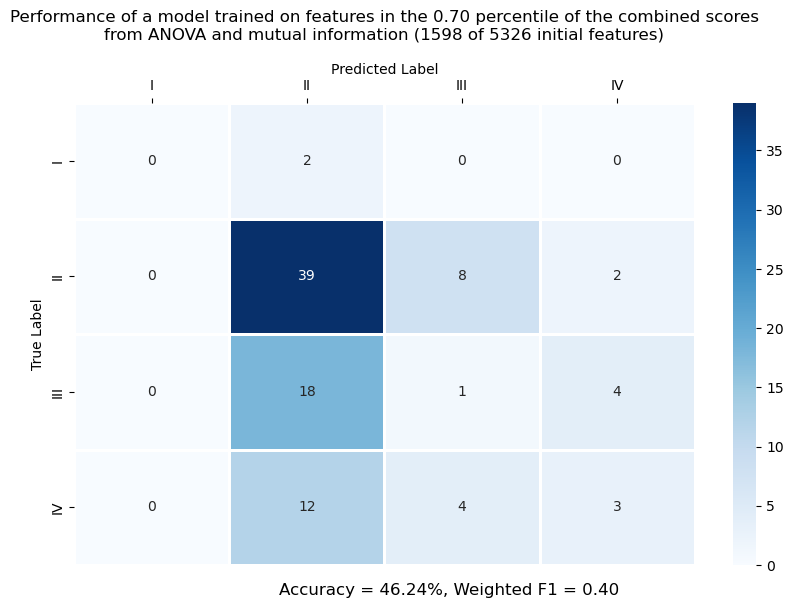

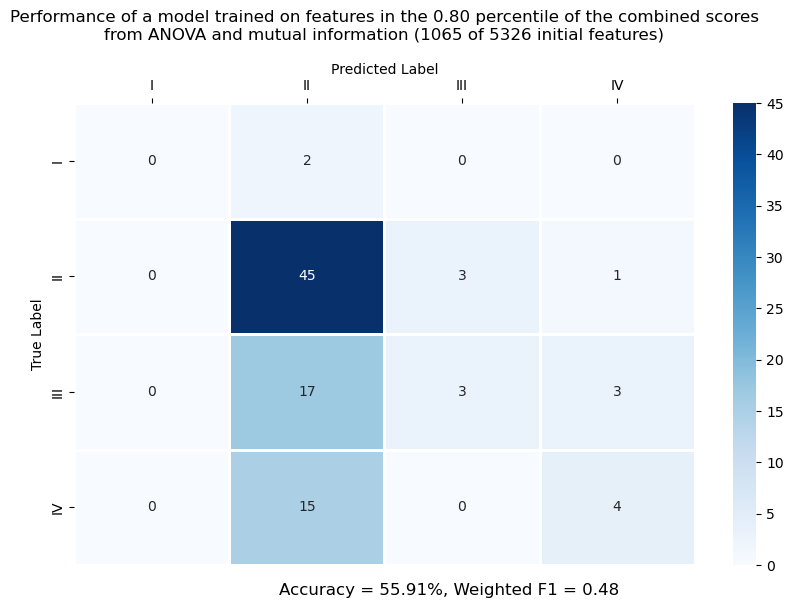

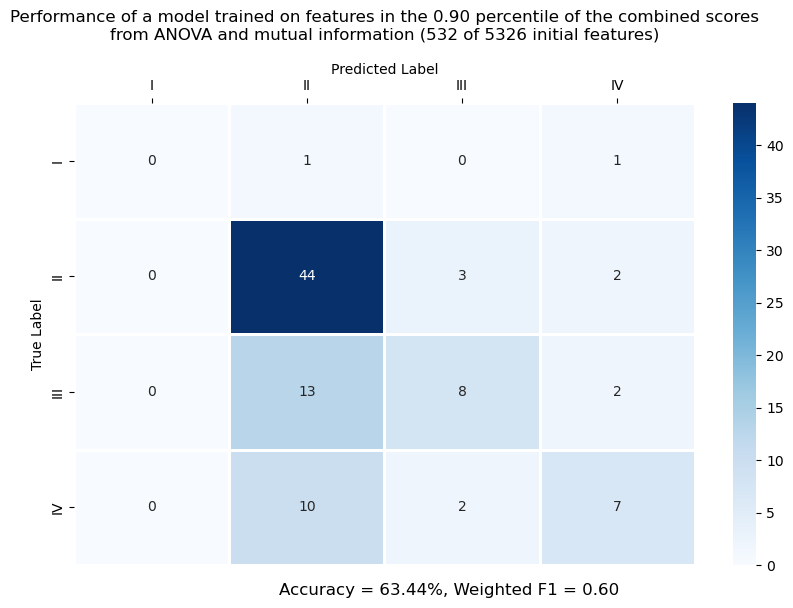

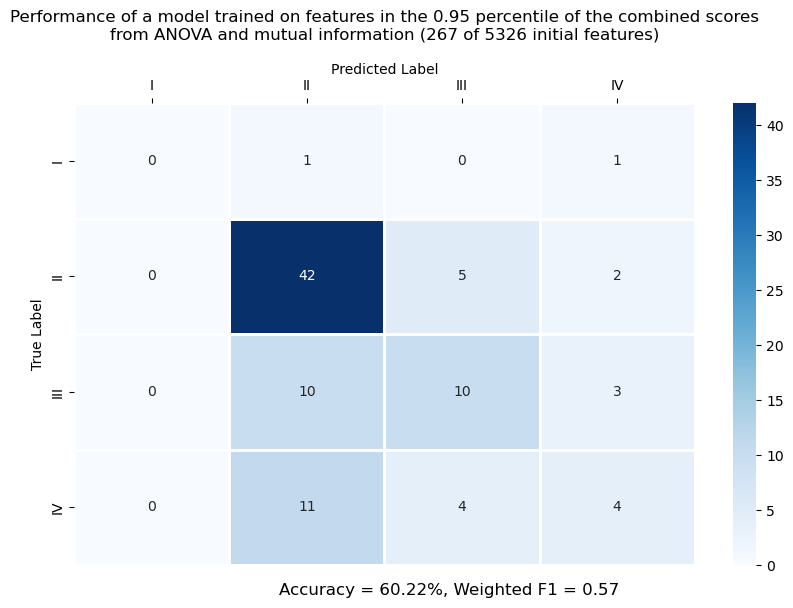

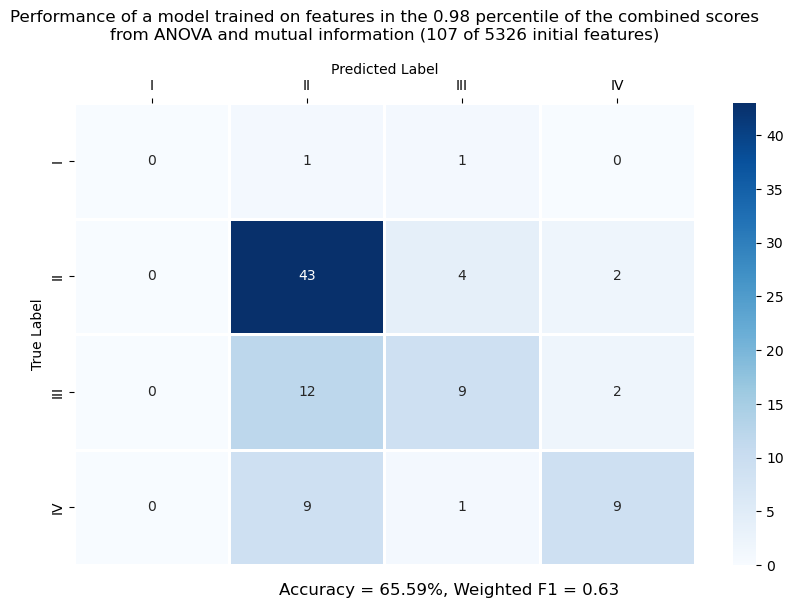

In [38]:
for percentile in percentiles:
    features_indices = select_by_percentile(features_order, percentile)
    best_features = X_train_dr_multiclass.columns[features_indices].tolist()
    X_train_reduced = X_train_multiclass.loc[:, best_features + ['Stage']]

    objective_func = partial(
        objective,
        X_train=X_train_reduced,
        stratification_groups=stratification_groups_multiclass,
        xgb_config=xgb_config,
        scoring=scoring_func
    )
    study = optuna.create_study(direction='maximize')
    study.optimize(objective_func, n_trials=50)

    best_params = {**study.best_params, **xgb_config}
    best_xgb = XGBClassifier(**best_params)

    y_pred = stratified_cross_val_predict(
        estimator=best_xgb,
        df=X_train_reduced,
        stratification_groups=stratification_groups_multiclass,
        label_col='Stage',
        n_splits=10
    )
    y_true = list(X_train_reduced['Stage'].values)
    labels = list(labels_encoding_multiclass.keys())

    accuracy = accuracy_score(y_true, y_pred.astype(int))
    f1 = f1_score(y_true, y_pred.astype(int), average='weighted')
    cm = confusion_matrix(y_true, y_pred.astype(int))
    
    title = f'Performance of a model trained on features in the {percentile/100:.2f} percentile of the combined scores' \
            f'\nfrom ANOVA and mutual information ({len(features_indices[0])} of {len(X_train_dr_multiclass.columns)} initial features)'
    scores_subtitle = f'Accuracy = {accuracy*100:.2f}%, Weighted F1 = {f1:.2f}'
    
    filename = f'combined_criteria_{percentile}_percentile.png'
    plot_confusion_matrix(cm, labels, title, scores_subtitle, output_path=os.path.join(output_dir_multiclass, filename))
    
    filename = f'combined_criteria_{percentile}_percentile_used_features.obj'
    output_path=os.path.join(output_dir_multiclass, filename)
    with open(output_path, 'wb') as file:
        pickle.dump(best_features, file)

### Binary classification

In [39]:
anova_features_order = np.zeros(f_scores_binary.size, dtype=int)
anova_features_order[np.argsort(f_scores_binary)] = np.arange(f_scores_binary.size)

mi_features_order = np.zeros(mi_scores_binary.size, dtype=int)
mi_features_order[np.argsort(mi_scores_binary)] = np.arange(mi_scores_binary.size)

features_order = anova_features_order + mi_features_order

results_combined_criteria = pd.DataFrame(data={
    'feature': X_train_dr_binary.columns,
    'order': features_order
})
results_combined_criteria.sort_values('order', ascending=False).reset_index(drop=True).head(10)

,feature,order
0,FAM208B,10607
1,CCDC7,10605
2,MAP7D1,10581
3,ZZEF1,10576
4,GPSM3,10568
5,ANK1,10559
6,MBNL3,10553
7,LRRFIP1,10534
8,LANCL3,10527
9,FADS1,10524


In [40]:
percentiles = [70, 80, 90, 95, 98]

xgb_config = {
    'objective': 'binary:logistic',
    'tree_method': 'gpu_hist',
    'gpu_id': 0,
    'random_state': random_state,
}

scoring_func = balanced_accuracy_score

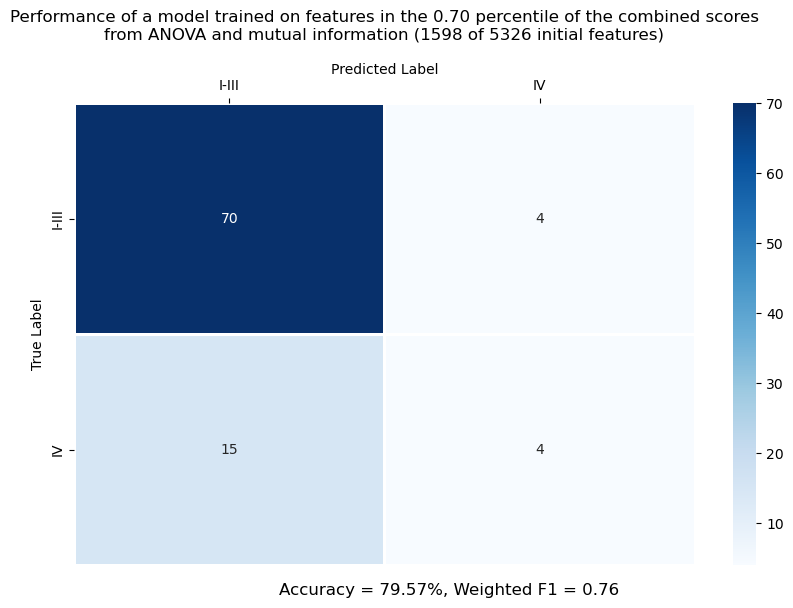

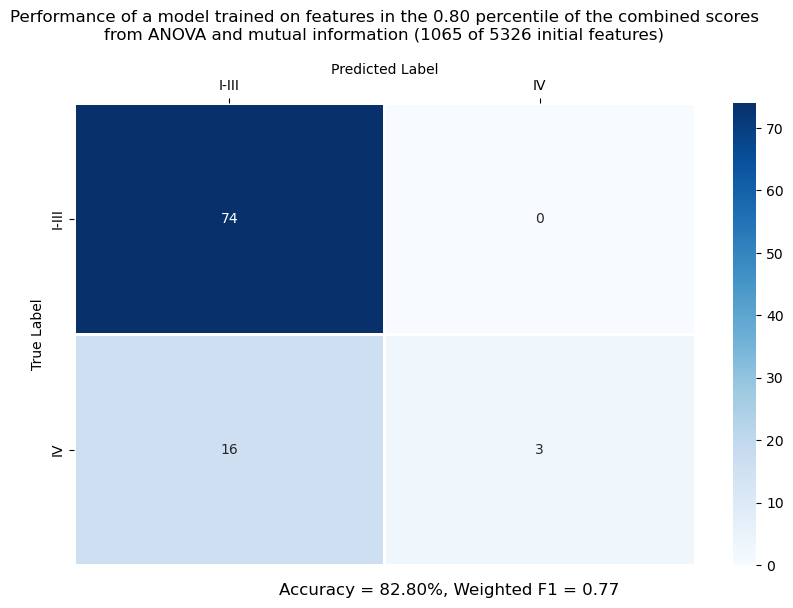

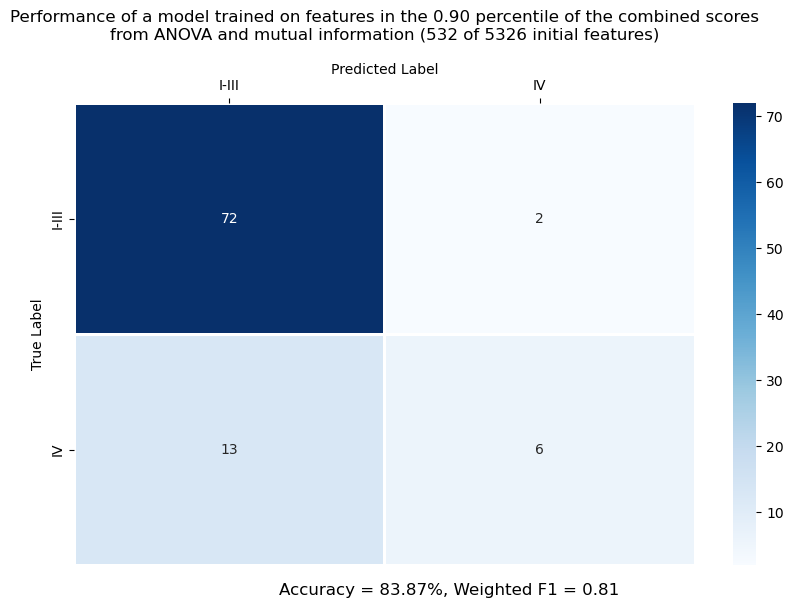

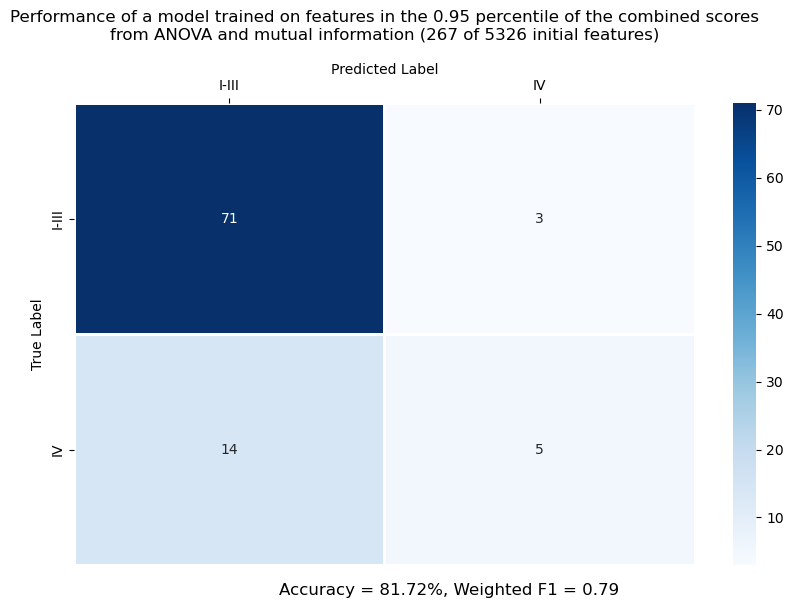

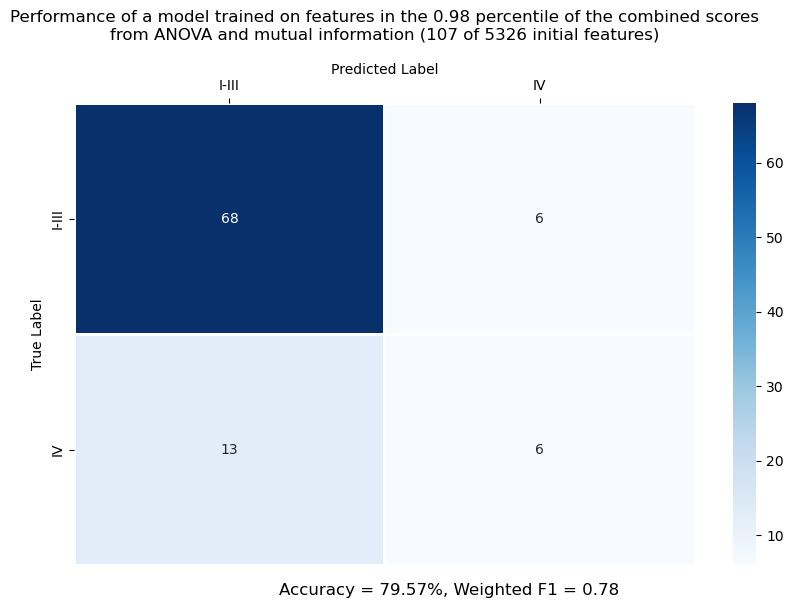

In [41]:
for percentile in percentiles:
    features_indices = select_by_percentile(features_order, percentile)
    best_features = X_train_dr_binary.columns[features_indices].tolist()
    X_train_reduced = X_train_binary.loc[:, best_features + ['Stage']]

    objective_func = partial(
        objective,
        X_train=X_train_reduced,
        stratification_groups=stratification_groups_binary,
        xgb_config=xgb_config,
        scoring=scoring_func
    )
    study = optuna.create_study(direction='maximize')
    study.optimize(objective_func, n_trials=50)

    best_params = {**study.best_params, **xgb_config}
    best_xgb = XGBClassifier(**best_params)

    y_pred = stratified_cross_val_predict(
        estimator=best_xgb,
        df=X_train_reduced,
        stratification_groups=stratification_groups_binary,
        label_col='Stage',
        n_splits=10
    )
    y_true = list(X_train_reduced['Stage'].values)
    labels = list(labels_encoding_binary.keys())

    accuracy = accuracy_score(y_true, y_pred.astype(int))
    f1 = f1_score(y_true, y_pred.astype(int), average='weighted')
    cm = confusion_matrix(y_true, y_pred.astype(int))
    
    title = f'Performance of a model trained on features in the {percentile/100:.2f} percentile of the combined scores' \
            f'\nfrom ANOVA and mutual information ({len(features_indices[0])} of {len(X_train_dr_binary.columns)} initial features)'
    scores_subtitle = f'Accuracy = {accuracy*100:.2f}%, Weighted F1 = {f1:.2f}'
    
    filename = f'combined_criteria_{percentile}_percentile.png'
    plot_confusion_matrix(cm, labels, title, scores_subtitle, output_path=os.path.join(output_dir_binary, filename))
    
    filename = f'combined_criteria_{percentile}_percentile_used_features.obj'
    output_path=os.path.join(output_dir_binary, filename)
    with open(output_path, 'wb') as file:
        pickle.dump(best_features, file)

### Binary classification (stages: I-II vs III-IV)

In [42]:
anova_features_order = np.zeros(f_scores_binary_2.size, dtype=int)
anova_features_order[np.argsort(f_scores_binary_2)] = np.arange(f_scores_binary_2.size)

mi_features_order = np.zeros(mi_scores_binary_2.size, dtype=int)
mi_features_order[np.argsort(mi_scores_binary_2)] = np.arange(mi_scores_binary_2.size)

features_order = anova_features_order + mi_features_order

results_combined_criteria = pd.DataFrame(data={
    'feature': X_train_dr_binary_2.columns,
    'order': features_order
})
results_combined_criteria.sort_values('order', ascending=False).reset_index(drop=True).head(10)

,feature,order
0,ASGR2,10628
1,GSDMD,10618
2,SCFD2,10617
3,LRRFIP1,10614
4,MFSD10,10547
5,RECQL5,10527
6,MAP7D1,10523
7,UBB,10513
8,SF3B3,10502
9,ATP5F1,10491


In [43]:
percentiles = [70, 80, 90, 95, 98]

xgb_config = {
    'objective': 'binary:logistic',
    'tree_method': 'gpu_hist',
    'gpu_id': 0,
    'random_state': random_state,
}

scoring_func = balanced_accuracy_score

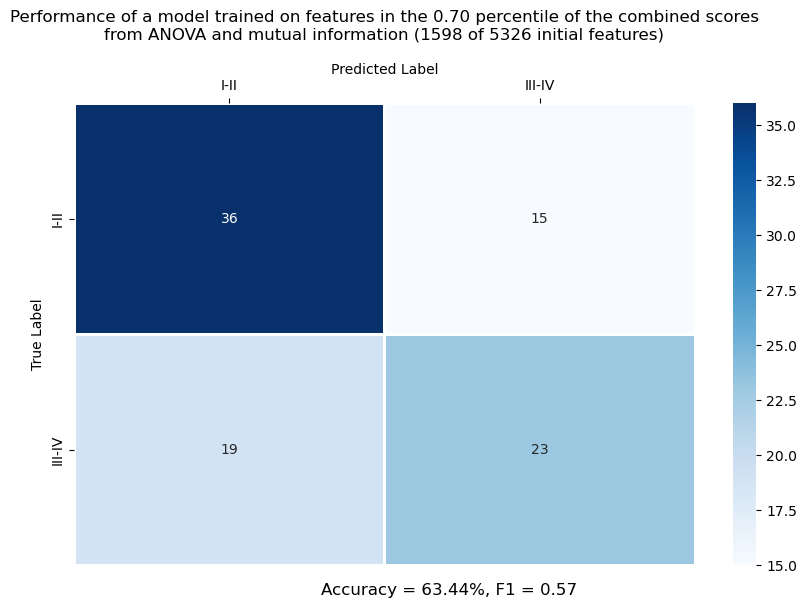

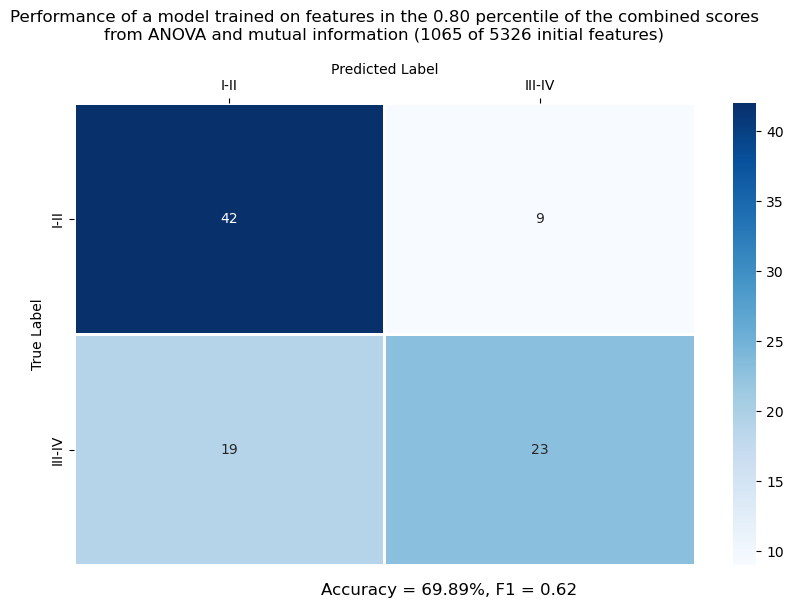

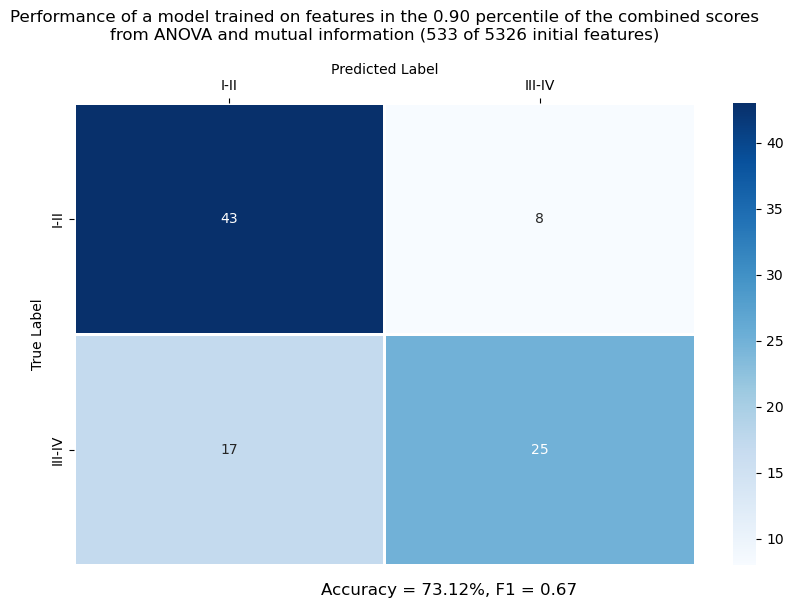

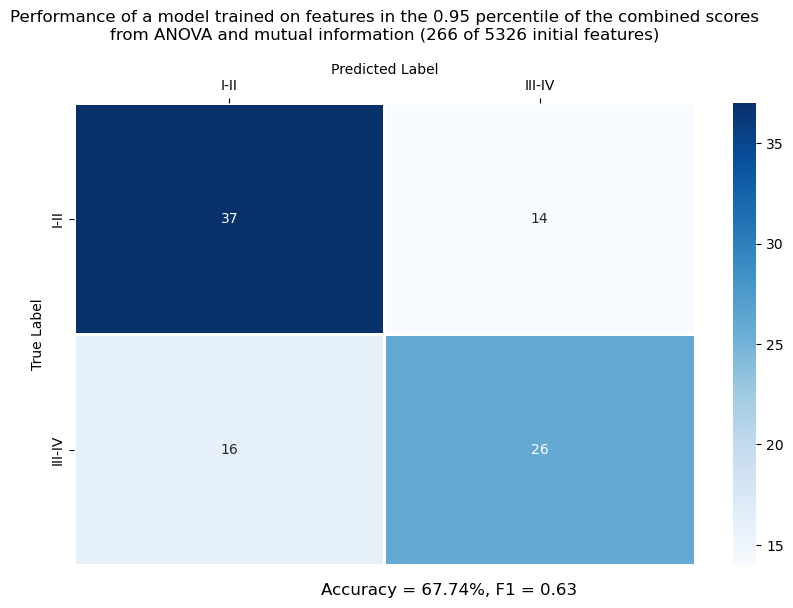

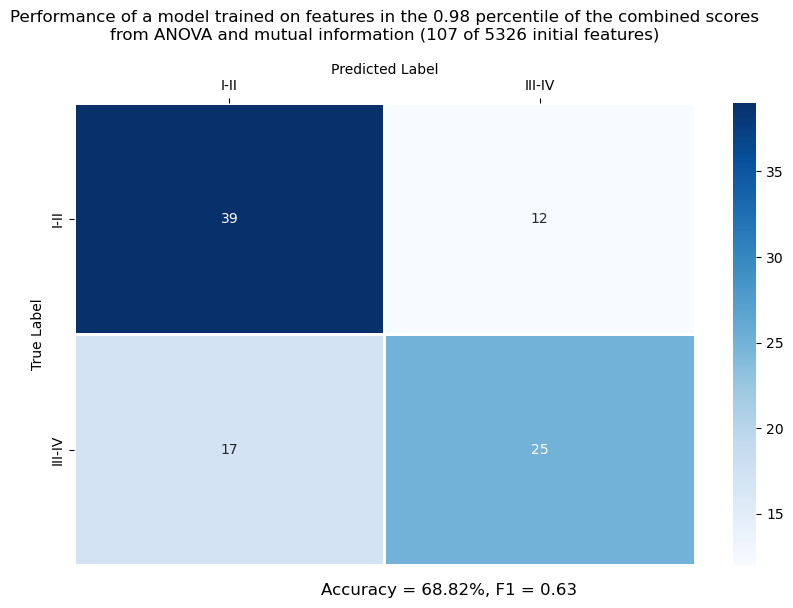

In [44]:
for percentile in percentiles:
    features_indices = select_by_percentile(features_order, percentile)
    best_features = X_train_dr_binary_2.columns[features_indices].tolist()
    X_train_reduced = X_train_binary_2.loc[:, best_features + ['Stage']]

    objective_func = partial(
        objective,
        X_train=X_train_reduced,
        stratification_groups=stratification_groups_binary_2,
        xgb_config=xgb_config,
        scoring=scoring_func
    )
    study = optuna.create_study(direction='maximize')
    study.optimize(objective_func, n_trials=50)

    best_params = {**study.best_params, **xgb_config}
    best_xgb = XGBClassifier(**best_params)

    y_pred = stratified_cross_val_predict(
        estimator=best_xgb,
        df=X_train_reduced,
        stratification_groups=stratification_groups_binary_2,
        label_col='Stage',
        n_splits=10
    )
    y_true = list(X_train_reduced['Stage'].values)
    labels = list(labels_encoding_binary_2.keys())

    accuracy = accuracy_score(y_true, y_pred.astype(int))
    f1 = f1_score(y_true, y_pred.astype(int))
    cm = confusion_matrix(y_true, y_pred.astype(int))
    
    title = f'Performance of a model trained on features in the {percentile/100:.2f} percentile of the combined scores' \
            f'\nfrom ANOVA and mutual information ({len(features_indices[0])} of {len(X_train_dr_binary_2.columns)} initial features)'
    scores_subtitle = f'Accuracy = {accuracy*100:.2f}%, F1 = {f1:.2f}'
    
    filename = f'combined_criteria_{percentile}_percentile.png'
    plot_confusion_matrix(cm, labels, title, scores_subtitle, output_path=os.path.join(output_dir_binary_2, filename))
    
    filename = f'combined_criteria_{percentile}_percentile_used_features.obj'
    output_path=os.path.join(output_dir_binary_2, filename)
    with open(output_path, 'wb') as file:
        pickle.dump(best_features, file)

## Feature importances

Recursive elimination of features based on their importance scores obtained from trained models. At each iteration, the least important features are rejected and then the XGBoost model is trained, fine-tuned, and cross-validated on the reduced subset of columns.

In [45]:
n_iterations = 5
percentile = 50

In [46]:
def get_feature_importances(estimator, X_train, label_col):
    y = X_train[label_col]
    X = X_train.drop(columns=[label_col])
    
    estimator.fit(X=X, y=y, verbose=False)
    feature_importances = estimator.feature_importances_
    
    return feature_importances

### Multiclass classification

In [47]:
xgb_config = {
    'objective': 'multi:softmax',
    'tree_method': 'gpu_hist',
    'gpu_id': 0,
    'random_state': random_state,
    'num_class': 4,
}

scoring_func = partial(f1_score, average='weighted')

In [48]:
y_train_multiclass = X_train_multiclass['Stage'].values
X_train_multiclass = X_train_multiclass.drop(columns=['Stage'])
n_initial_columns = len(X_train_multiclass.columns)

best_features = X_train_multiclass.columns
X_train_reduced_multiclass = X_train_multiclass.loc[:, best_features]
X_train_reduced_multiclass['Stage'] = y_train_multiclass

objective_func = partial(
    objective,
    X_train=X_train_reduced_multiclass,
    stratification_groups=stratification_groups_multiclass,
    xgb_config=xgb_config,
    scoring=scoring_func
)
study = optuna.create_study(direction='maximize')
study.optimize(objective_func, n_trials=50)

best_params = {**study.best_params, **xgb_config}
best_xgb = XGBClassifier(**best_params)

feature_importances = get_feature_importances(best_xgb, X_train_reduced_multiclass, 'Stage')

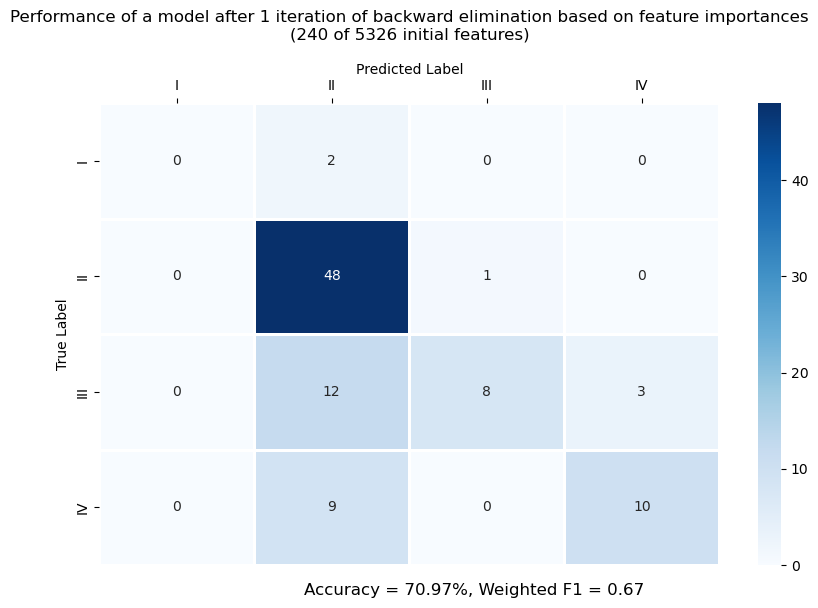

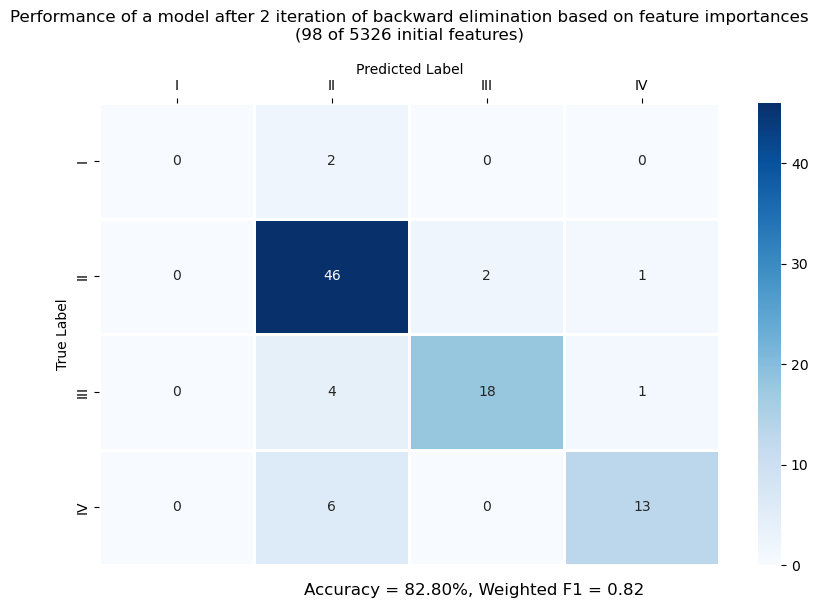

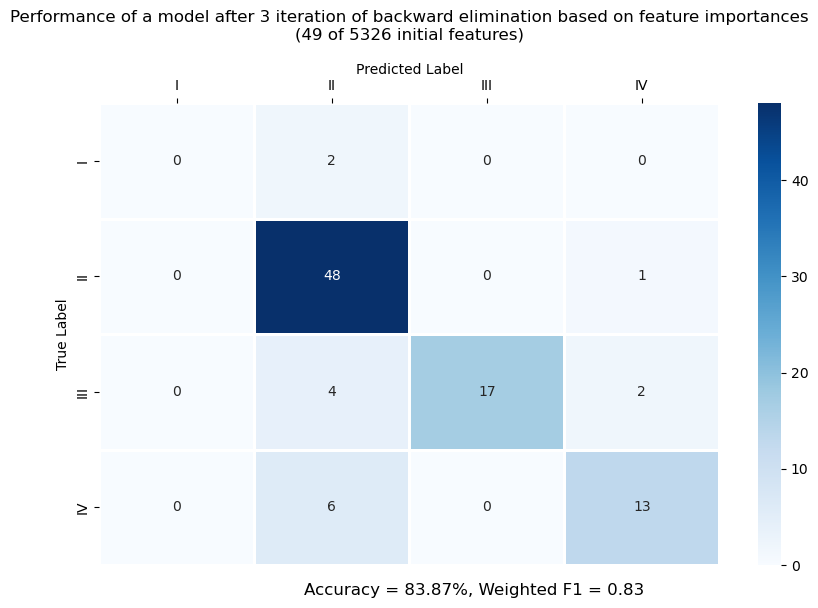

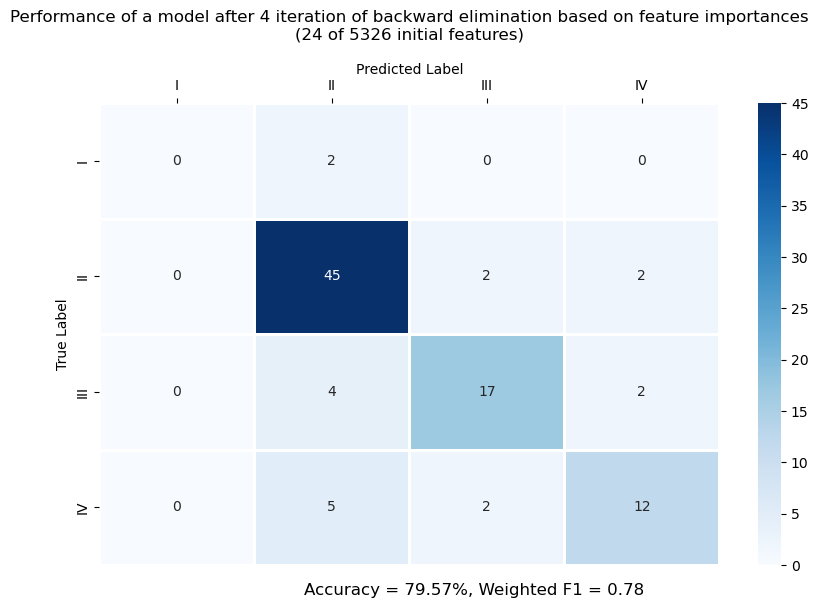

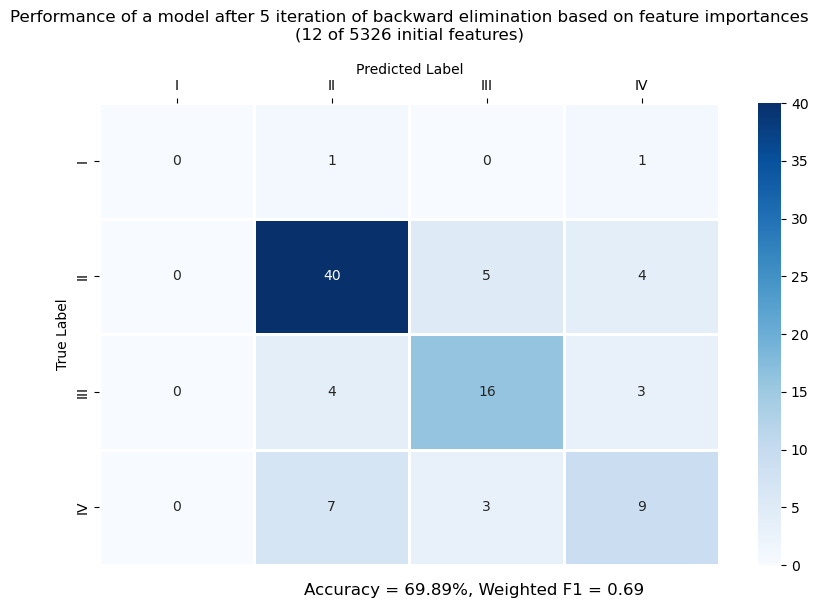

In [49]:
for i in range(1, n_iterations + 1):
    features_indices = select_by_percentile(feature_importances, percentile)
    best_features = best_features[features_indices]
    X_train_reduced_multiclass = X_train_multiclass.loc[:, best_features]
    X_train_reduced_multiclass['Stage'] = y_train_multiclass

    objective_func = partial(
        objective,
        X_train=X_train_reduced_multiclass,
        stratification_groups=stratification_groups_multiclass,
        xgb_config=xgb_config,
        scoring=scoring_func
    )
    study = optuna.create_study(direction='maximize')
    study.optimize(objective_func, n_trials=50)

    best_params = {**study.best_params, **xgb_config}
    best_xgb = XGBClassifier(**best_params)
    
    feature_importances = get_feature_importances(best_xgb, X_train_reduced_multiclass, 'Stage')

    y_pred = stratified_cross_val_predict(
        estimator=best_xgb,
        df=X_train_reduced_multiclass,
        stratification_groups=stratification_groups_multiclass,
        label_col='Stage',
        n_splits=10
    )
    y_true = list(X_train_reduced_multiclass['Stage'].values)
    labels = list(labels_encoding_multiclass.keys())

    accuracy = accuracy_score(y_true, y_pred.astype(int))
    f1 = f1_score(y_true, y_pred.astype(int), average='weighted')
    cm = confusion_matrix(y_true, y_pred.astype(int))

    title = f'Performance of a model after {i} iteration of backward elimination based on feature importances' \
            f'\n({len(best_features)} of {n_initial_columns} initial features)'
    scores_subtitle = f'Accuracy = {accuracy*100:.2f}%, Weighted F1 = {f1:.2f}'
    
    filename = f'feature_importances_backward_elimination_{i}_iteration.png'
    plot_confusion_matrix(cm, labels, title, scores_subtitle, output_path=os.path.join(output_dir_multiclass, filename))
    
    filename = f'feature_importances_backward_elimination_{i}_iteration_used_features.obj'
    output_path=os.path.join(output_dir_multiclass, filename)
    with open(output_path, 'wb') as file:
        pickle.dump(best_features.tolist(), file)

### Binary classification

In [50]:
xgb_config = {
    'objective': 'binary:logistic',
    'tree_method': 'gpu_hist',
    'gpu_id': 0,
    'random_state': random_state,
}

scoring_func = balanced_accuracy_score

In [51]:
y_train_binary = X_train_binary['Stage'].values
X_train_binary = X_train_binary.drop(columns=['Stage'])
n_initial_columns = len(X_train_binary.columns)

best_features = X_train_binary.columns
X_train_reduced_binary = X_train_binary.loc[:, best_features]
X_train_reduced_binary['Stage'] = y_train_binary

objective_func = partial(
    objective,
    X_train=X_train_reduced_binary,
    stratification_groups=stratification_groups_binary,
    xgb_config=xgb_config,
    scoring=scoring_func
)
study = optuna.create_study(direction='maximize')
study.optimize(objective_func, n_trials=50)

best_params = {**study.best_params, **xgb_config}
best_xgb = XGBClassifier(**best_params)

feature_importances = get_feature_importances(best_xgb, X_train_reduced_binary, 'Stage')

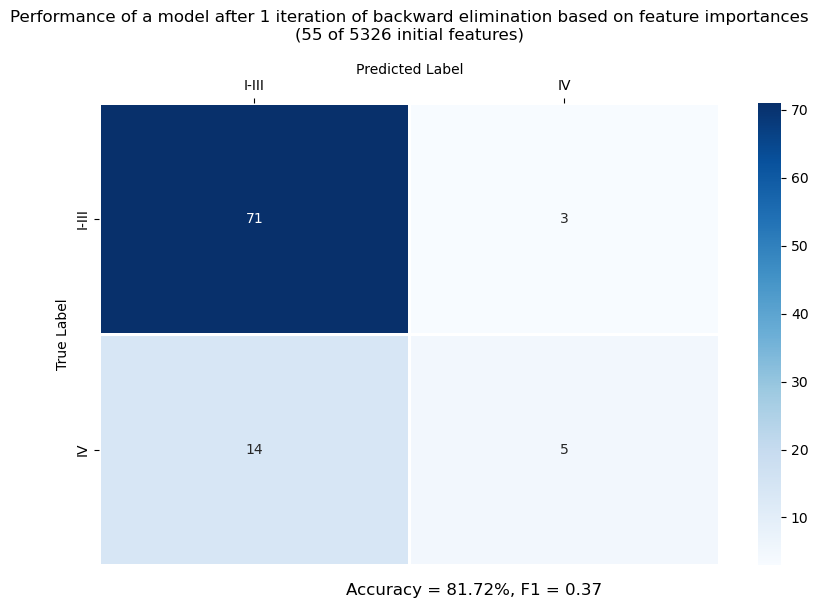

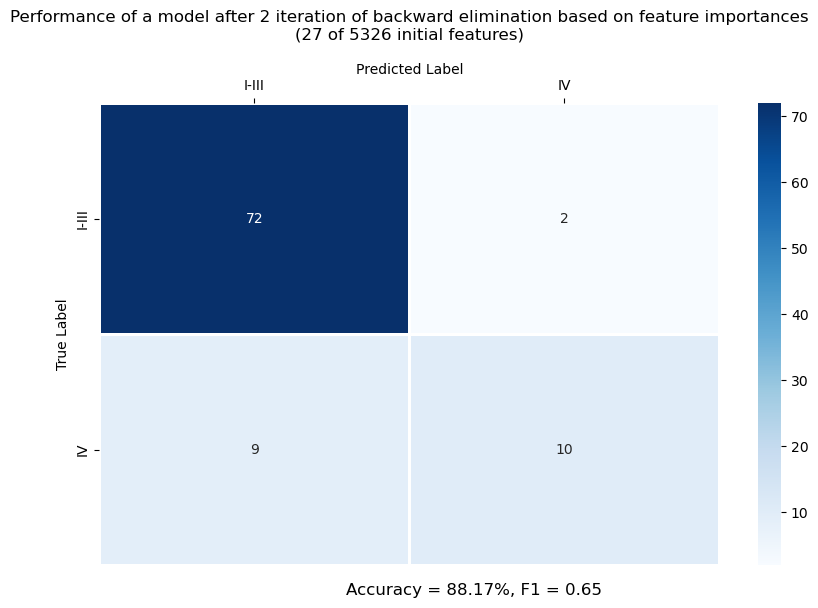

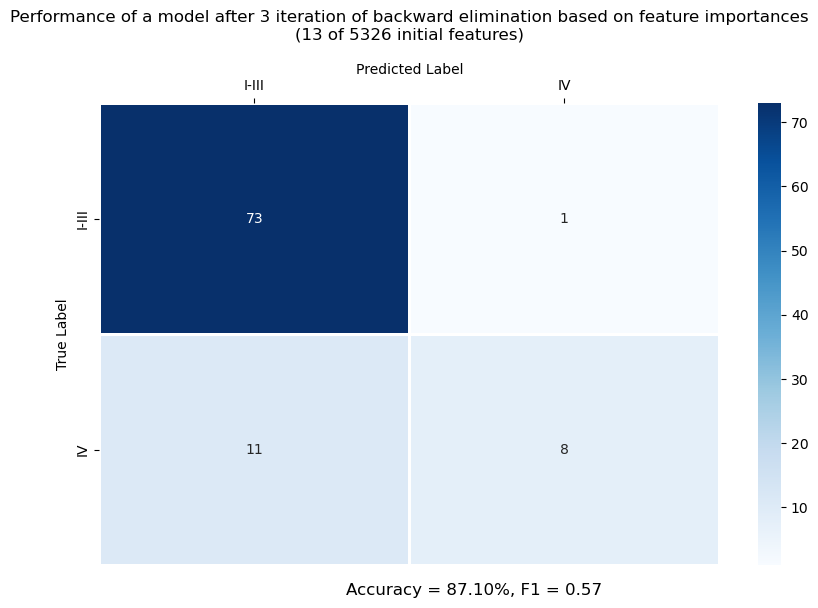

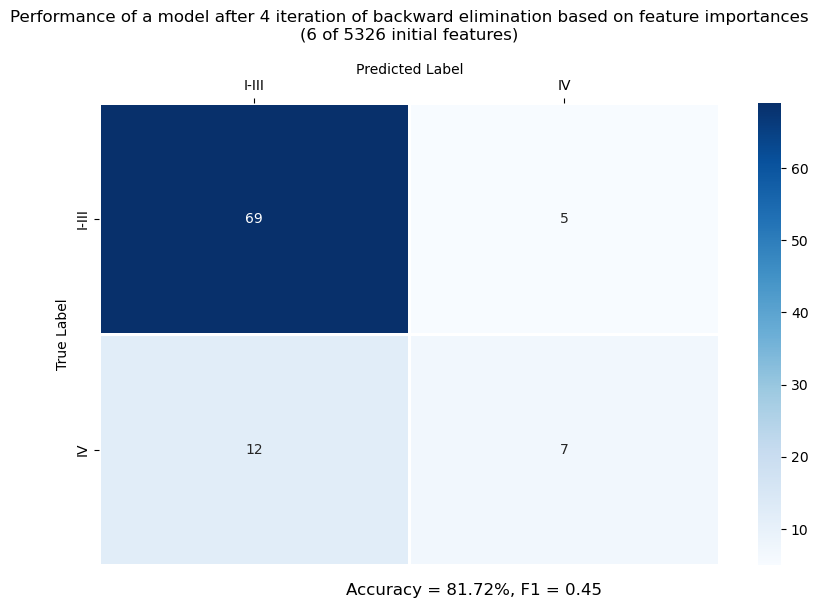

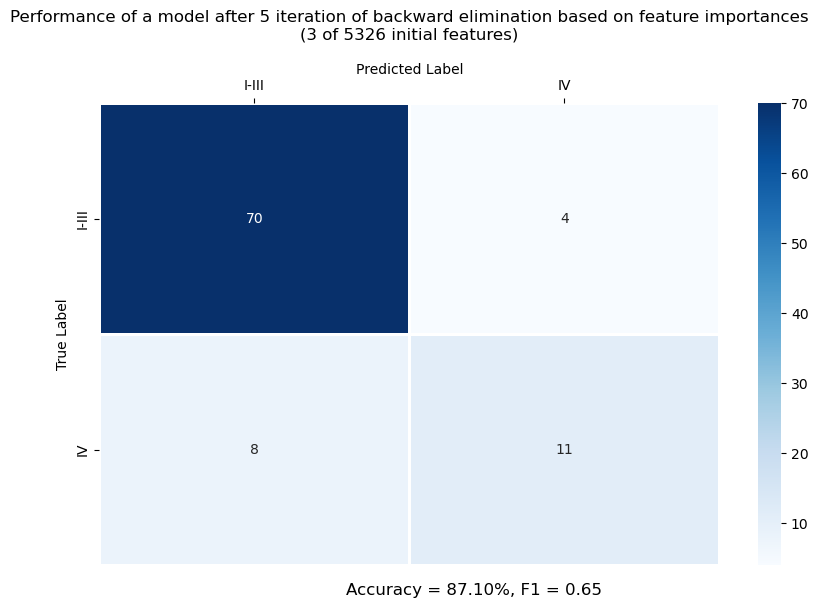

In [52]:
for i in range(1, n_iterations + 1):
    features_indices = select_by_percentile(feature_importances, percentile)
    best_features = best_features[features_indices]
    X_train_reduced_binary = X_train_binary.loc[:, best_features]
    X_train_reduced_binary['Stage'] = y_train_binary

    objective_func = partial(
        objective,
        X_train=X_train_reduced_binary,
        stratification_groups=stratification_groups_binary,
        xgb_config=xgb_config,
        scoring=scoring_func
    )
    study = optuna.create_study(direction='maximize')
    study.optimize(objective_func, n_trials=50)

    best_params = {**study.best_params, **xgb_config}
    best_xgb = XGBClassifier(**best_params)
    
    feature_importances = get_feature_importances(best_xgb, X_train_reduced_binary, 'Stage')

    y_pred = stratified_cross_val_predict(
        estimator=best_xgb,
        df=X_train_reduced_binary,
        stratification_groups=stratification_groups_binary,
        label_col='Stage',
        n_splits=10
    )
    y_true = list(X_train_reduced_binary['Stage'].values)
    labels = list(labels_encoding_binary.keys())

    accuracy = accuracy_score(y_true, y_pred.astype(int))
    f1 = f1_score(y_true, y_pred.astype(int))
    cm = confusion_matrix(y_true, y_pred.astype(int))

    title = f'Performance of a model after {i} iteration of backward elimination based on feature importances' \
            f'\n({len(best_features)} of {n_initial_columns} initial features)'
    scores_subtitle = f'Accuracy = {accuracy*100:.2f}%, F1 = {f1:.2f}'
    
    filename = f'feature_importances_backward_elimination_{i}_iteration.png'
    plot_confusion_matrix(cm, labels, title, scores_subtitle, output_path=os.path.join(output_dir_binary, filename))
    
    filename = f'feature_importances_backward_elimination_{i}_iteration_used_features.obj'
    output_path=os.path.join(output_dir_binary, filename)
    with open(output_path, 'wb') as file:
        pickle.dump(best_features.tolist(), file)

### Binary classification (stages: I-II vs III-IV)

In [53]:
xgb_config = {
    'objective': 'binary:logistic',
    'tree_method': 'gpu_hist',
    'gpu_id': 0,
    'random_state': random_state,
}

scoring_func = balanced_accuracy_score

In [54]:
y_train_binary_2 = X_train_binary_2['Stage'].values
X_train_binary_2 = X_train_binary_2.drop(columns=['Stage'])
n_initial_columns = len(X_train_binary_2.columns)

best_features = X_train_binary_2.columns
X_train_reduced_binary_2 = X_train_binary_2.loc[:, best_features]
X_train_reduced_binary_2['Stage'] = y_train_binary_2

objective_func = partial(
    objective,
    X_train=X_train_reduced_binary_2,
    stratification_groups=stratification_groups_binary_2,
    xgb_config=xgb_config,
    scoring=scoring_func
)
study = optuna.create_study(direction='maximize')
study.optimize(objective_func, n_trials=50)

best_params = {**study.best_params, **xgb_config}
best_xgb = XGBClassifier(**best_params)

feature_importances = get_feature_importances(best_xgb, X_train_reduced_binary_2, 'Stage')

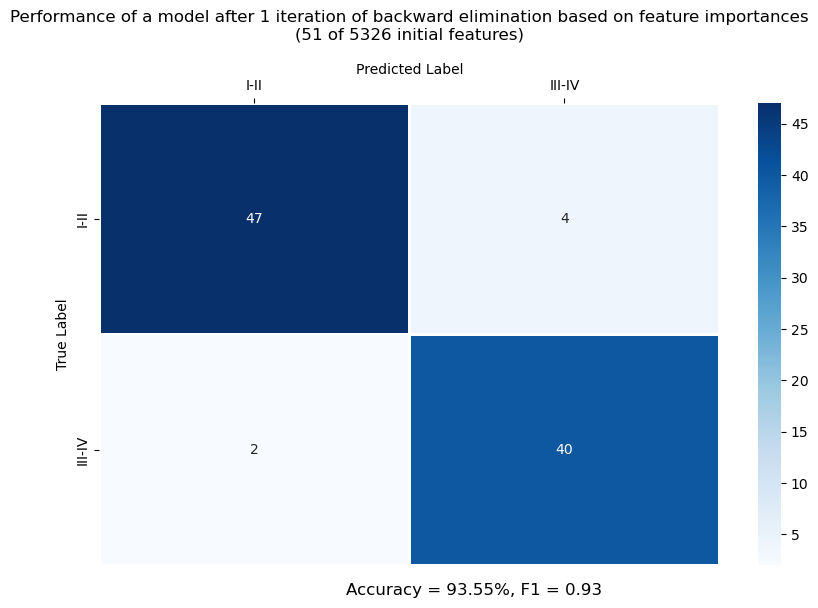

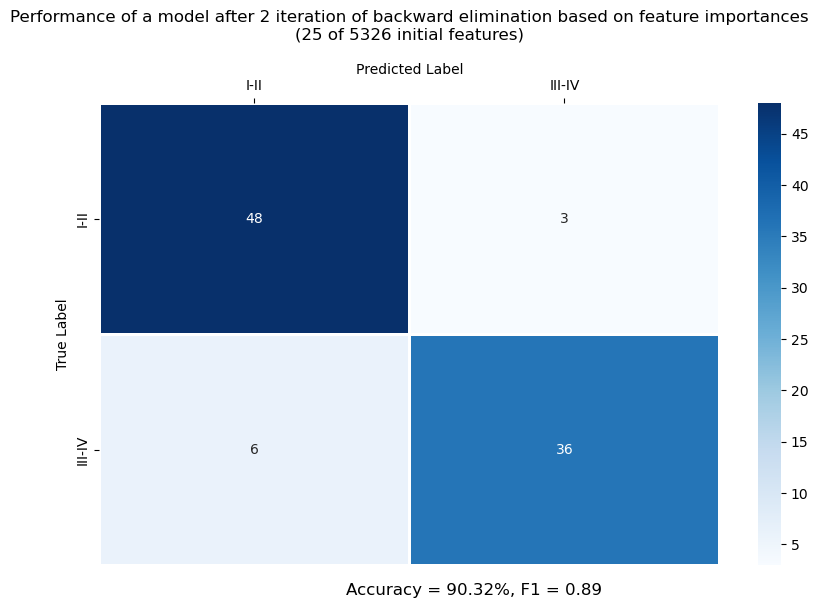

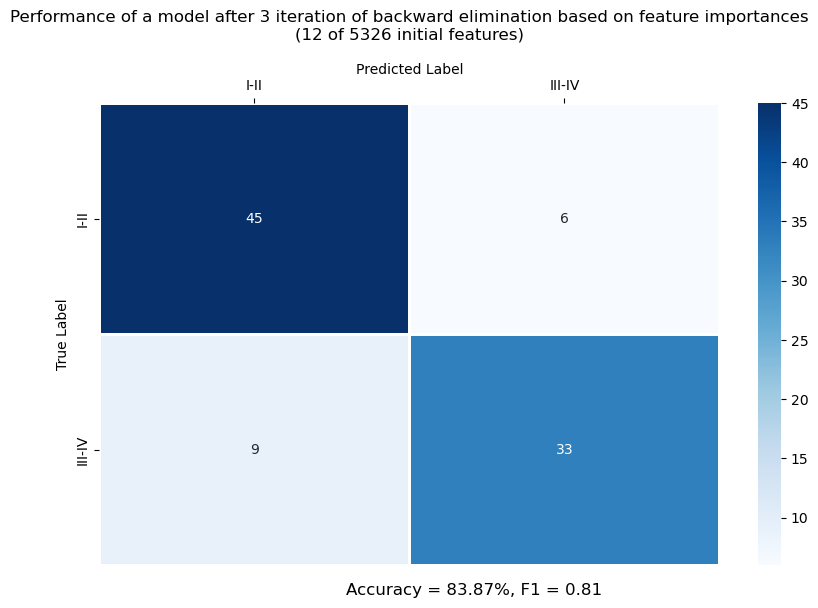

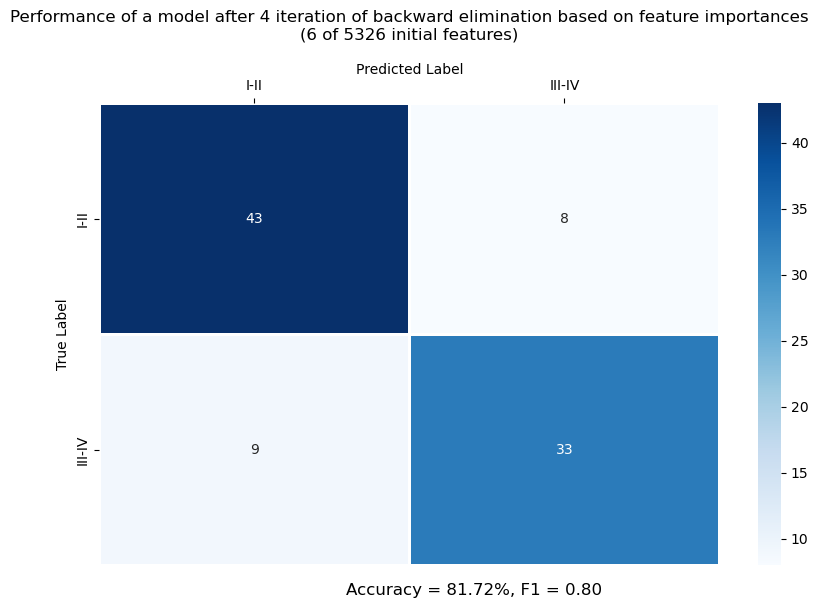

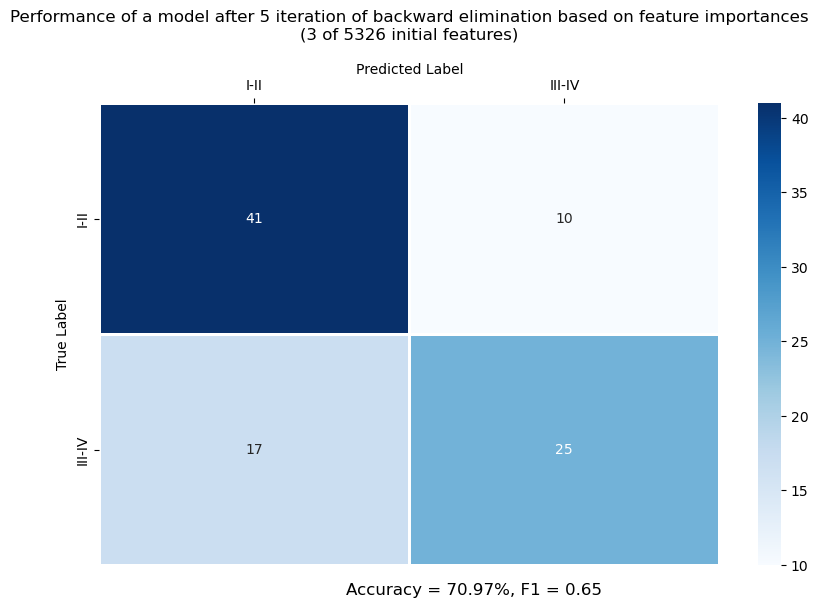

In [55]:
for i in range(1, n_iterations + 1):
    features_indices = select_by_percentile(feature_importances, percentile)
    best_features = best_features[features_indices]
    X_train_reduced_binary_2 = X_train_binary_2.loc[:, best_features]
    X_train_reduced_binary_2['Stage'] = y_train_binary_2

    objective_func = partial(
        objective,
        X_train=X_train_reduced_binary_2,
        stratification_groups=stratification_groups_binary_2,
        xgb_config=xgb_config,
        scoring=scoring_func
    )
    study = optuna.create_study(direction='maximize')
    study.optimize(objective_func, n_trials=50)

    best_params = {**study.best_params, **xgb_config}
    best_xgb = XGBClassifier(**best_params)
    
    feature_importances = get_feature_importances(best_xgb, X_train_reduced_binary_2, 'Stage')

    y_pred = stratified_cross_val_predict(
        estimator=best_xgb,
        df=X_train_reduced_binary_2,
        stratification_groups=stratification_groups_binary_2,
        label_col='Stage',
        n_splits=10
    )
    y_true = list(X_train_reduced_binary_2['Stage'].values)
    labels = list(labels_encoding_binary_2.keys())

    accuracy = accuracy_score(y_true, y_pred.astype(int))
    f1 = f1_score(y_true, y_pred.astype(int))
    cm = confusion_matrix(y_true, y_pred.astype(int))

    title = f'Performance of a model after {i} iteration of backward elimination based on feature importances' \
            f'\n({len(best_features)} of {n_initial_columns} initial features)'
    scores_subtitle = f'Accuracy = {accuracy*100:.2f}%, F1 = {f1:.2f}'
    
    filename = f'feature_importances_backward_elimination_{i}_iteration.png'
    plot_confusion_matrix(cm, labels, title, scores_subtitle, output_path=os.path.join(output_dir_binary_2, filename))
    
    filename = f'feature_importances_backward_elimination_{i}_iteration_used_features.obj'
    output_path=os.path.join(output_dir_binary_2, filename)
    with open(output_path, 'wb') as file:
        pickle.dump(best_features.tolist(), file)